# Uncertainty quantification using conformal quantile regression 

In [1]:
import src.data.datasets as data
from sklearn.preprocessing import MinMaxScaler
import src.data.preprocessor as pre
from src.model.network import create_model, quantile_loss, create_MQDCNN, MultiQuantileLoss
import numpy as np
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from src.utils import compute_coverage_len, plot_quantiles, compute_quantile

#in order not to use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

# Load and scale FD001 (stationary case)

In [2]:
dataset = data.get_dataset("CMAPSS1")
window_size = 30


scaler = MinMaxScaler(feature_range=(-1, 1))
train = pre.apply_scaling_fn(scaler.fit_transform, dataset["train"])
test = pre.apply_scaling_fn(scaler.transform, dataset["test"])
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
cmapss_op_list = ["time", "os1", "os2", "os3"]
removable_cols += cmapss_op_list
train = train.drop(removable_cols, axis=1)
test = test.drop(removable_cols, axis=1)
train = pre.dataframe_to_supervised(train, n_in=window_size-1)
test = pre.dataframe_to_supervised(test, n_in=window_size-1)


X = np.vstack(train[0])
y = np.vstack(train[1])



X_test = []
y_test = []
for i in range(len(test[0])):
    X_test.append(test[0][i][-1,:,:,:])
    y_test.append(test[1][i][-1,:])

X_test = np.array(X_test)
y_test = np.array(y_test)

# Conformal Prediction with evaluation

1. Split training data into training and calibration+validation data (ratio: 20%)
2. train the model (it could be either regression or quantile regression) 
3. Sample calibration+validation data randomly and calibrate data on calibration data and test it on validation data (repeat this procedure R times)
4. Each time save avg coverage, left covergae, and lenght as well as length histogram

## Ordinary regression

In [3]:
R = 100 # number of times we cailbrate and validate the model
alpha = 0.1
epochs = 100 # training epochs
optimizer = Adam(learning_rate=1e-3) # model optimizer
calval_size = 2000 # 2000 of training data is used for cailbration and validation
calib_size = 1000 # 1000 of cailbration+validation data is used for cailbration
val_size = calval_size - calib_size # 1000 of cailbration+validation data is used for validation

X_train, X_calval, y_train, y_calval = train_test_split(X, y, test_size=calval_size, random_state=0)
DCNN = create_model(window_size=30, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

cvg = []
left_cvg = []
avg_len = []

for r in range(R):
    X_val, X_calib, y_val, y_calib = train_test_split(X_calval, y_calval, test_size=calib_size)

    y_hat_calib = DCNN.predict(x=X_calib, verbose=0)
    y_hat_val = DCNN.predict(x=X_val, verbose=0)
    scores= np.abs(y_calib - y_hat_calib) # scores for ordinary regression problem
    q = compute_quantile(scores, alpha)
    left_coverage, coverage, avg_length =  compute_coverage_len(y_val, y_hat_val-q, y_hat_val+q)
    
    left_cvg.append(left_coverage)
    cvg.append(coverage)
    avg_len.append(avg_length)


l = np.floor((calib_size+1)*alpha)

cvg_theo_mean = 1- l/(calib_size+1)
cvg_theo_std = np.sqrt((l*(calib_size+1-l)*(calval_size+1))/(val_size*R*(calib_size+2)*(calib_size+1)^2)) 

Epoch 1/100
31/31 [==============================] - 8s 230ms/step - loss: 6688.3594 - root_mean_squared_error: 81.7824
Epoch 2/100
31/31 [==============================] - 7s 231ms/step - loss: 5859.1104 - root_mean_squared_error: 76.5448
Epoch 3/100
31/31 [==============================] - 7s 229ms/step - loss: 5443.6133 - root_mean_squared_error: 73.7808
Epoch 4/100
31/31 [==============================] - 7s 225ms/step - loss: 5067.3984 - root_mean_squared_error: 71.1857
Epoch 5/100
31/31 [==============================] - 7s 227ms/step - loss: 4721.4937 - root_mean_squared_error: 68.7131
Epoch 6/100
31/31 [==============================] - 7s 227ms/step - loss: 4400.8735 - root_mean_squared_error: 66.3391
Epoch 7/100
31/31 [==============================] - 7s 234ms/step - loss: 4102.6411 - root_mean_squared_error: 64.0519
Epoch 8/100
31/31 [==============================] - 7s 224ms/step - loss: 3825.4502 - root_mean_squared_error: 61.8502
Epoch 9/100
31/31 [=====================

Theoretical coverage mean is 0.9000999000999002, while the emperical one is 0.8997499999999999
Theoretical coverage std is 0.04239699152396806, while the emperical one is 0.013742179594227414


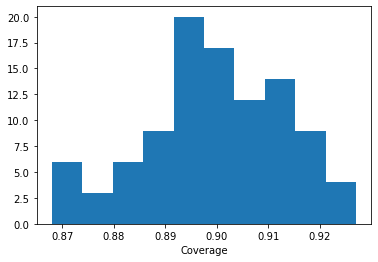

In [4]:
plt.hist(cvg)
plt.xlabel('Coverage')
print(f"Theoretical coverage mean is {cvg_theo_mean}, while the emperical one is {np.mean(cvg)}")
print(f"Theoretical coverage std is {cvg_theo_std}, while the emperical one is {np.std(cvg)}")

Text(0.5, 0, 'Average interval length')

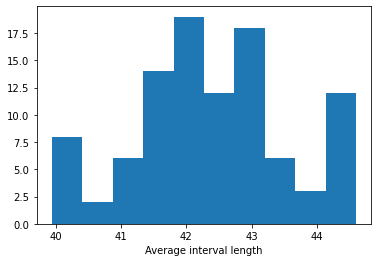

In [5]:
plt.hist(avg_len)
plt.xlabel('Average interval length')

In [11]:
np.mean(avg_len)

42.35748

# How small can prediction intervals be? 
The answer to this question is determined by the oracle that has the idealized prediction lengths

See this paper: [Distribution-Free Predictive Inference for Regression](https://www.tandfonline.com/doi/pdf/10.1080/01621459.2017.1307116?needAccess=true)

In [6]:
q_n = np.quantile(np.abs(y_train - DCNN.predict(X_train)), 1-alpha)
print(f"The oracle tells that the interval lengths must be {2*q_n}")

492/492 [==============================] - 5s 10ms/step
The oracle tells that the interval lengths must be 40.53388977050781


In [7]:
q_n = np.quantile(np.abs(y_val - DCNN.predict(X_val)), 1-alpha)
print(f"The oracle tells that the interval lengths must be {2*q_n}")

32/32 [==============================] - 1s 16ms/step
The oracle tells that the interval lengths must be 42.82177505493164


In [10]:
q_n = np.quantile(np.abs(y_calval - DCNN.predict(X_calval)), 1-alpha)
print(f"The oracle tells that the interval lengths must be {2*q_n}")

63/63 [==============================] - 1s 9ms/step
The oracle tells that the interval lengths must be 42.18911132812501


In [8]:
DCNN.evaluate(X_calval, y_calval)

63/63 [==============================] - 1s 11ms/step - loss: 142.4110 - root_mean_squared_error: 11.9336


[142.41098022460938, 11.93360710144043]

In [9]:
DCNN.evaluate(X_test, y_test)

4/4 [==============================] - 0s 9ms/step - loss: 181.4646 - root_mean_squared_error: 13.4709


[181.46461486816406, 13.470880508422852]

## Quantile regression 

In [3]:
R = 100 # number of times we cailbrate and validate the model
alpha = 0.1
alpha_low = alpha/5
alpha_high = alpha - alpha_low
quantiles = [alpha/2, 1 - alpha/2]
epochs = 150 # training epochs
optimizer = Adam(learning_rate=1e-3) # model optimizer
loss_func = MultiQuantileLoss(quantiles=quantiles)

calval_size = 2000 # 2000 of training data is used for cailbration and validation
calib_size = 1000 # 1000 of cailbration+validation data is used for cailbration
val_size = calval_size - calib_size # 1000 of cailbration+validation data is used for validation

X_train, X_calval, y_train, y_calval = train_test_split(X, y, test_size=calval_size, random_state=0)
MQDCNN = create_MQDCNN(quantiles=quantiles, window_size=30, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
MQDCNN.compile(optimizer=optimizer, loss=loss_func, metrics=[RootMeanSquaredError()])
MQDCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/150
31/31 [==============================] - 5s 144ms/step - loss: 72.9249 - q0_loss: 4.0314 - q1_loss: 68.8936 - q0_root_mean_squared_error: 90.7796 - q1_root_mean_squared_error: 82.4174
Epoch 2/150
31/31 [==============================] - 5s 147ms/step - loss: 65.3802 - q0_loss: 3.9242 - q1_loss: 61.4561 - q0_root_mean_squared_error: 88.3439 - q1_root_mean_squared_error: 76.1975
Epoch 3/150
31/31 [==============================] - 5s 147ms/step - loss: 62.3075 - q0_loss: 3.8568 - q1_loss: 58.4507 - q0_root_mean_squared_error: 86.0223 - q1_root_mean_squared_error: 73.2800
Epoch 4/150
31/31 [==============================] - 5s 166ms/step - loss: 59.5274 - q0_loss: 3.8154 - q1_loss: 55.7120 - q0_root_mean_squared_error: 84.6657 - q1_root_mean_squared_error: 70.5640
Epoch 5/150
31/31 [==============================] - 5s 156ms/step - loss: 56.8807 - q0_loss: 3.7510 - q1_loss: 53.1297 - q0_root_mean_squared_error: 83.4392 - q1_root_mean_squared_error: 67.9579
Epoch 6/150
31/31 [=

In [4]:
OQ = [] #ordinary quantile regression results
CQ = [] #conformalized quantile regression resluts
CQLR = [] #conformalized quantile regression resluts with independent left and right modification 

lens = []
qs = []
q_lows = []
q_highs = []


for r in range(R):
    X_val, X_calib, y_val, y_calib = train_test_split(X_calval, y_calval, test_size=calib_size)

    y_hat_calib = MQDCNN.predict(x=X_calib, verbose=0)
    y_hat_val = MQDCNN.predict(x=X_val, verbose=0)

    scores_low = y_hat_calib[0] - y_calib
    scores_high = y_calib - y_hat_calib[1] 
    scores = np.maximum(scores_low, scores_high)
    q = compute_quantile(scores, alpha)
    q_low = compute_quantile(scores_low, alpha_low)
    q_high = compute_quantile(scores_high, alpha_high)

    lens.append(y_hat_val[1] - y_hat_val[0])
    qs.append(q)
    q_lows.append(q_low)
    q_highs.append(q_high)

    OQ.append(compute_coverage_len(y_val, y_hat_val[0], y_hat_val[1]))
    CQ.append(compute_coverage_len(y_val, y_hat_val[0]-q, y_hat_val[1]+q))
    CQLR.append(compute_coverage_len(y_val, y_hat_val[0]-q_low, y_hat_val[1]+q_high))

OQ_left_coverage, OQ_coverage, OQ_avg_length = zip(*OQ)
CQ_left_coverage, CQ_coverage, CQ_avg_length = zip(*CQ)
CQLR_left_coverage, CQLR_coverage, CQLR_avg_length = zip(*CQLR)


l = np.floor((calib_size+1)*alpha)

cvg_theo_mean = 1- l/(calib_size+1)
cvg_theo_std = np.sqrt((l*(calib_size+1-l)*(calval_size+1))/(val_size*R*(calib_size+2)*(calib_size+1)^2))

Theoretical coverage mean is 0.9000999000999002, while the emperical one for OQ is 0.93509
Theoretical coverage mean is 0.9000999000999002, while the emperical one for CQ is 0.9007800000000001
Theoretical coverage mean is 0.9000999000999002, while the emperical one for CQLR is 0.8981699999999999
Theoretical coverage std is 0.04239699152396806, while the emperical one for OQ is 0.0049901803574620065
Theoretical coverage std is 0.04239699152396806, while the emperical one for CQ is 0.011602223924748231
Theoretical coverage std is 0.04239699152396806, while the emperical one for CQLR is 0.012672059816778023


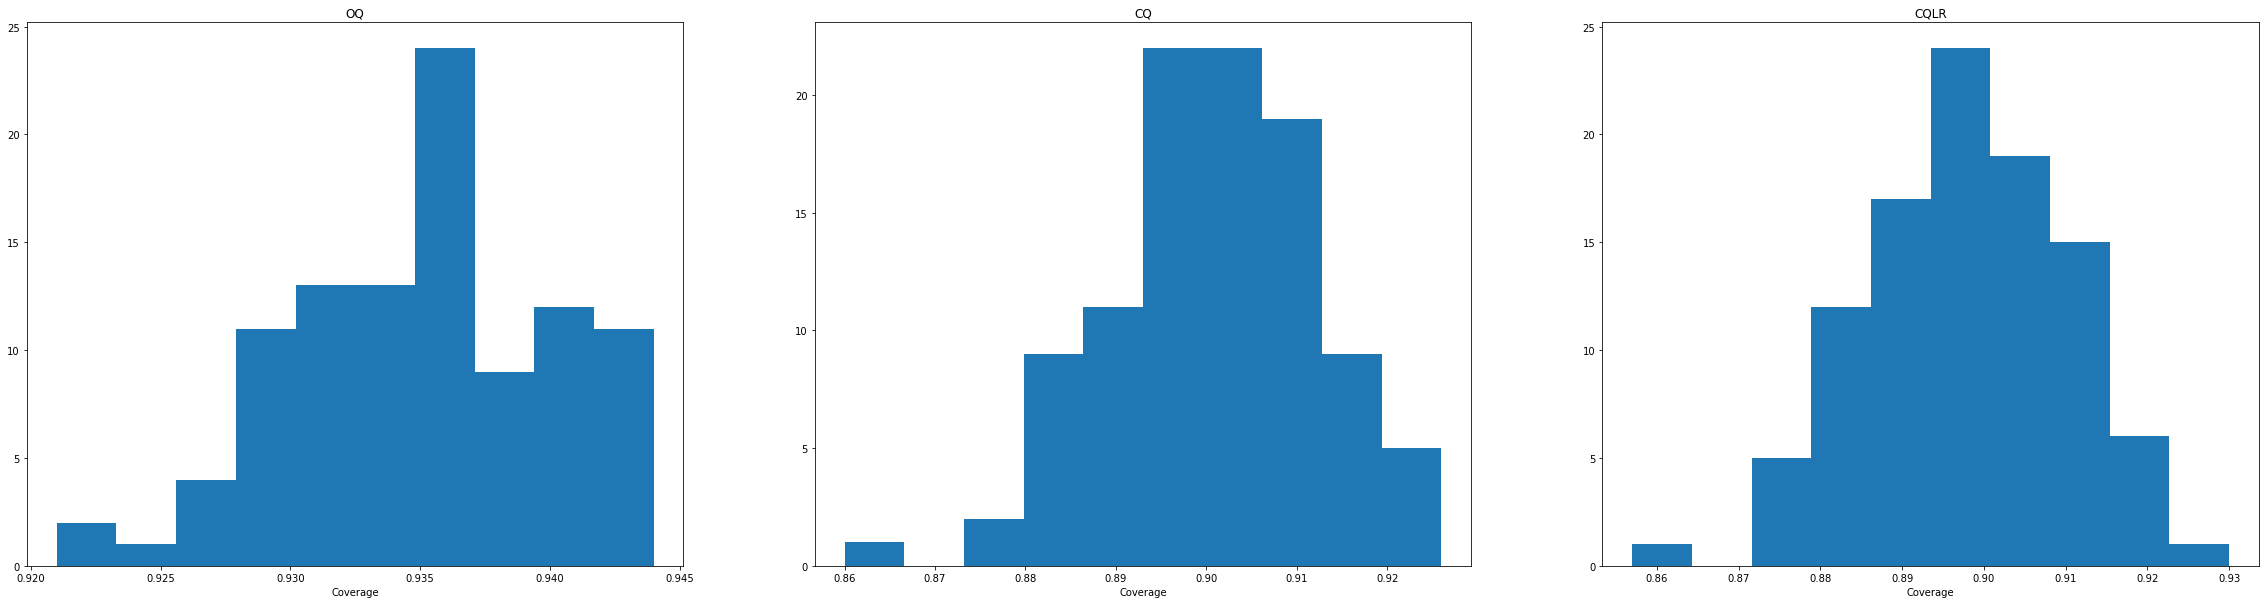

In [5]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(131)
ax.hist(OQ_coverage)
plt.xlabel('Coverage')
plt.title('OQ')



ax = fig.add_subplot(132)
ax.hist(CQ_coverage)
plt.xlabel('Coverage')
plt.title('CQ')

ax = fig.add_subplot(133)
ax.hist(CQLR_coverage)
plt.xlabel('Coverage')
plt.title('CQLR')


print(f"Theoretical coverage mean is {cvg_theo_mean}, while the emperical one for OQ is {np.mean(OQ_coverage)}")
print(f"Theoretical coverage mean is {cvg_theo_mean}, while the emperical one for CQ is {np.mean(CQ_coverage)}")
print(f"Theoretical coverage mean is {cvg_theo_mean}, while the emperical one for CQLR is {np.mean(CQLR_coverage)}")
print(f"Theoretical coverage std is {cvg_theo_std}, while the emperical one for OQ is {np.std(OQ_coverage)}")
print(f"Theoretical coverage std is {cvg_theo_std}, while the emperical one for CQ is {np.std(CQ_coverage)}")
print(f"Theoretical coverage std is {cvg_theo_std}, while the emperical one for CQLR is {np.std(CQLR_coverage)}")

Text(0.5, 1.0, 'CQLR')

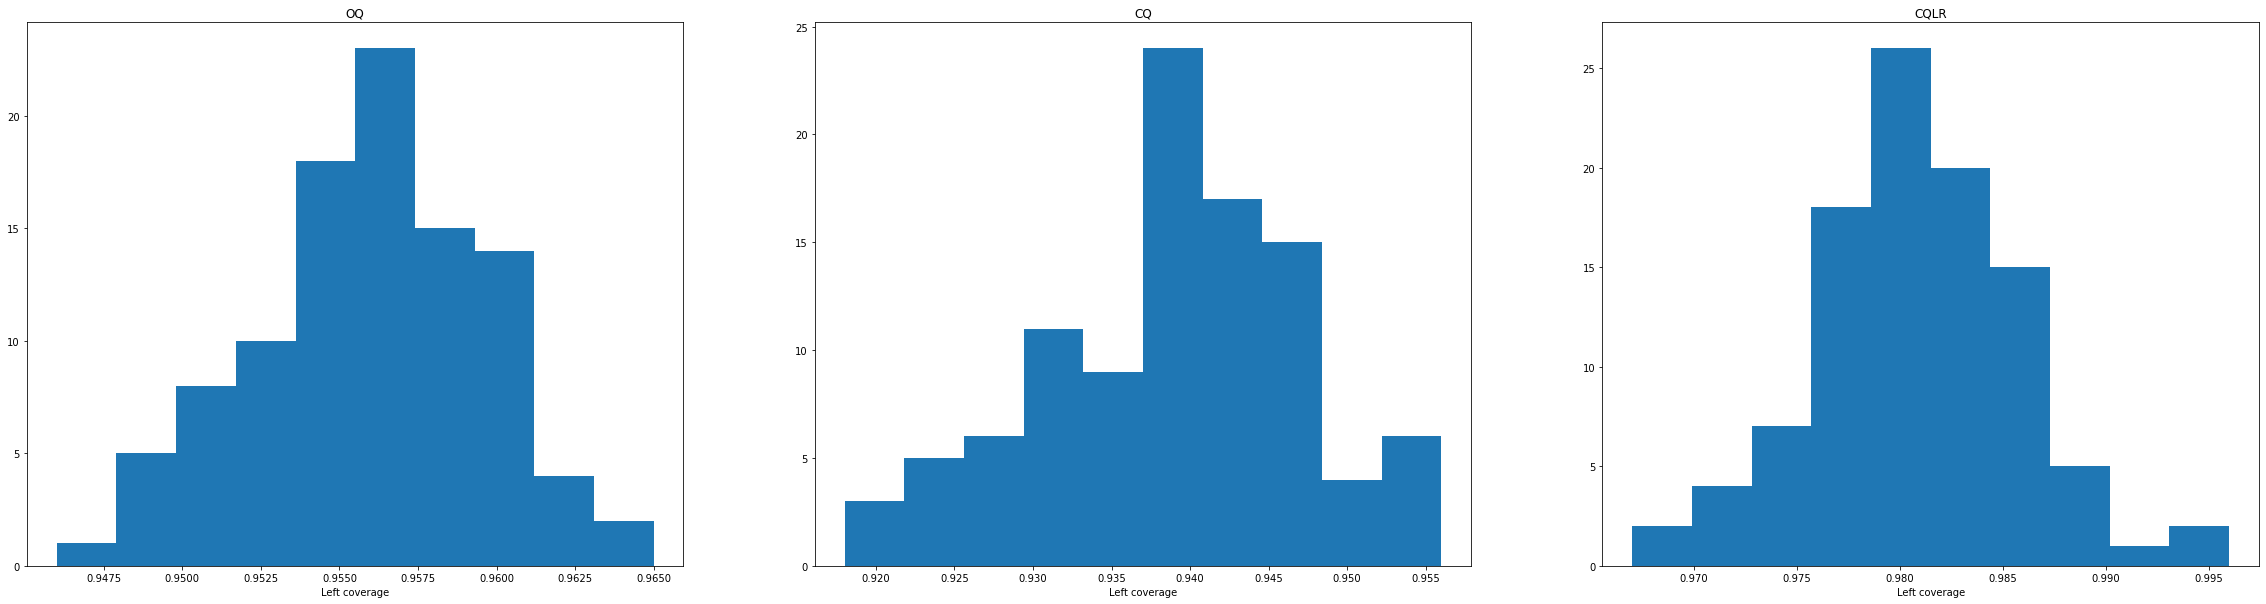

In [13]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(131)
ax.hist(OQ_left_coverage)
plt.xlabel('Left coverage')
plt.title('OQ')



ax = fig.add_subplot(132)
ax.hist(CQ_left_coverage)
plt.xlabel('Left coverage')
plt.title('CQ')

ax = fig.add_subplot(133)
ax.hist(CQLR_left_coverage)
plt.xlabel('Left coverage')
plt.title('CQLR')

Text(0.5, 1.0, 'CQLR')

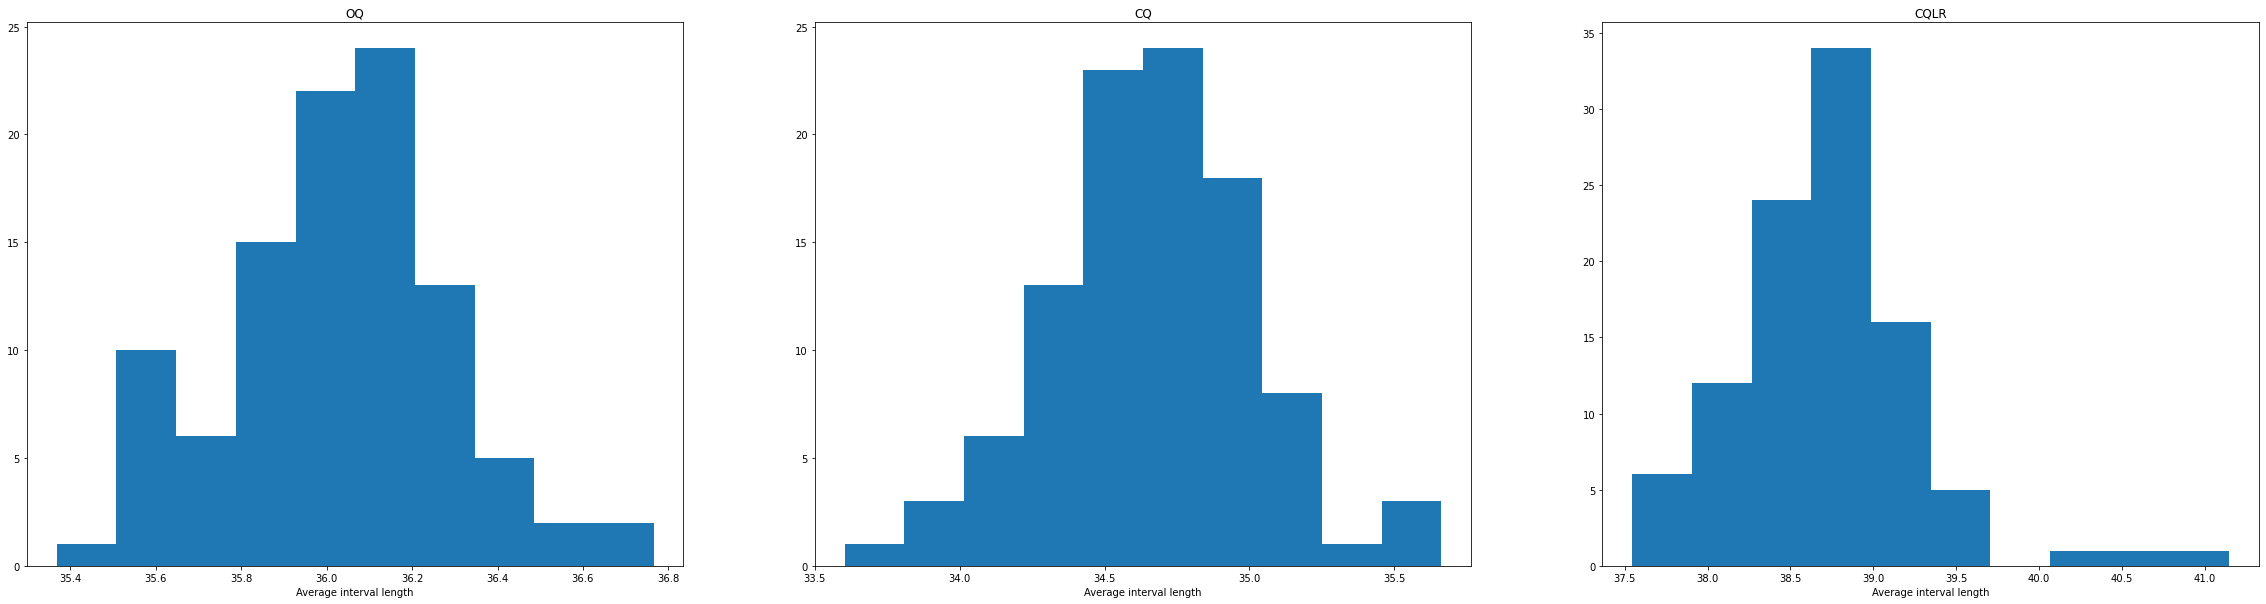

In [6]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(131)
ax.hist(OQ_avg_length)
plt.xlabel('Average interval length')
plt.title('OQ')



ax = fig.add_subplot(132)
ax.hist(CQ_avg_length)
plt.xlabel('Average interval length')
plt.title('CQ')

ax = fig.add_subplot(133)
ax.hist(CQLR_avg_length)
plt.xlabel('Average interval length')
plt.title('CQLR')


Text(0.5, 0, 'interval length')

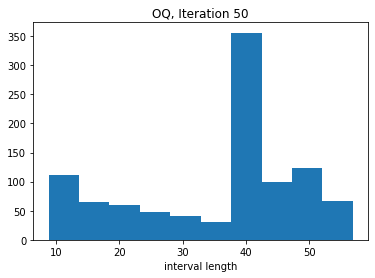

In [7]:
iter = 50
plt.hist(lens[iter])
plt.title(f'OQ, Iteration {iter}')
plt.xlabel('interval length')

Text(0.5, 1.0, "Histogram of q_highs's")

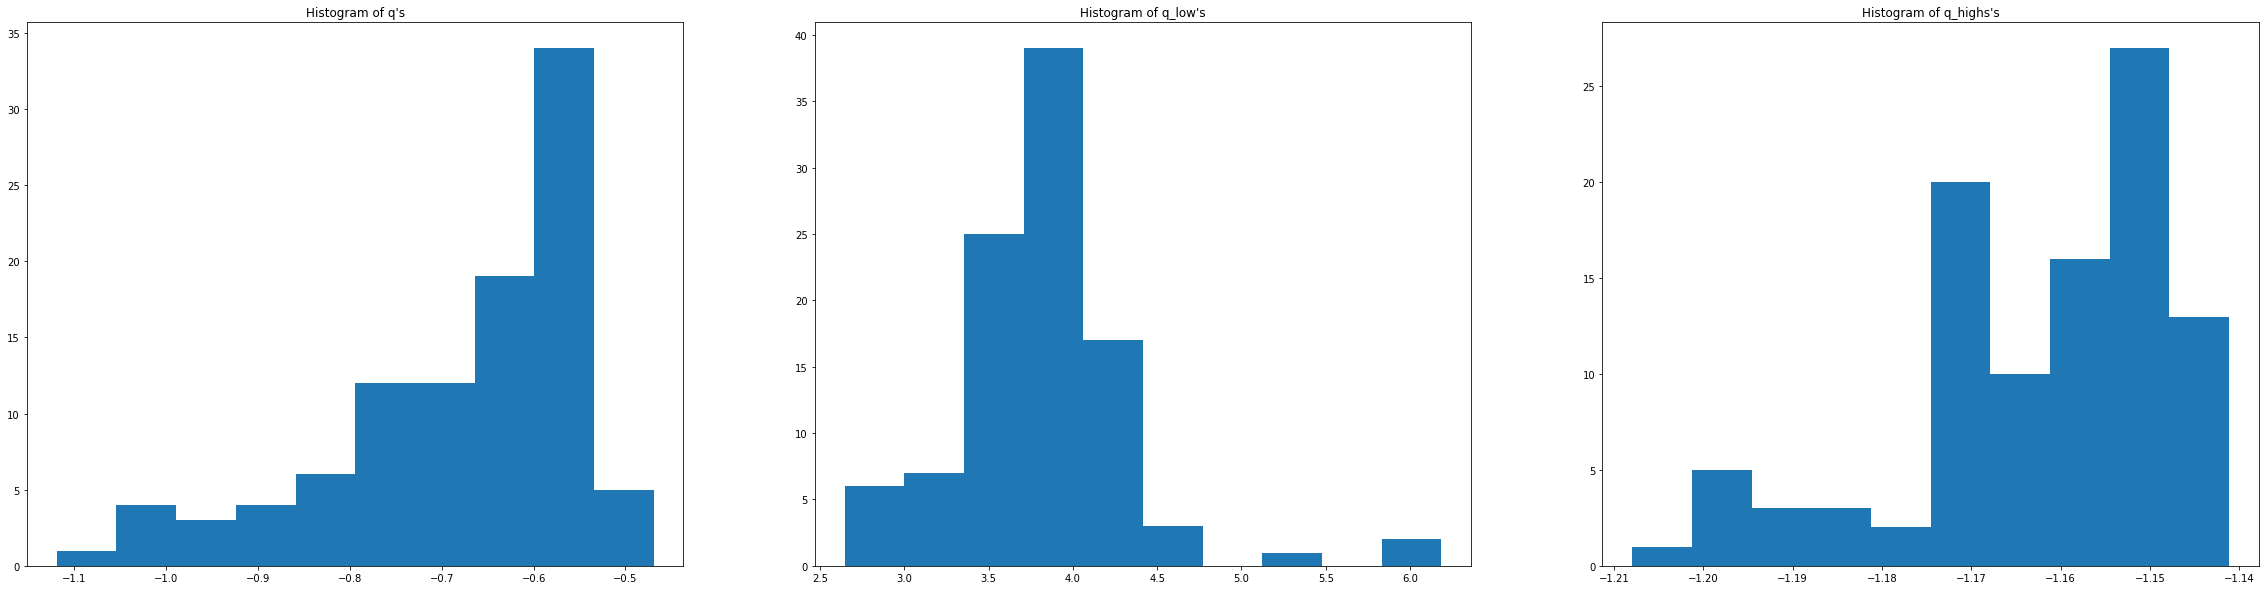

In [11]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(131)
ax.hist(qs)
plt.title("Histogram of q's")



ax = fig.add_subplot(132)
ax.hist(q_lows)
plt.title("Histogram of q_low's")

ax = fig.add_subplot(133)
ax.hist(q_highs)
plt.title("Histogram of q_highs's")

# A Deep Convolutional Neural Network with mean predictor  

In [3]:
DCNN = create_model(window_size=30, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 14, 10)        110       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 14, 1)         31        
                                                                 
 flatten (Flatten)           (None, 420)               0     

fit model on all training instances and evaluate it on test (according to their paper, test mse must be around 12.61) 

In [6]:
epochs = 100
optimizer = Adam(learning_rate=1e-3)

In [5]:
DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X, y=y, batch_size = 512, epochs = epochs)
DCNN.evaluate(X_test, y_test)

Epoch 1/100
35/35 [==============================] - 6s 174ms/step - loss: 6949.0273 - root_mean_squared_error: 83.3608
Epoch 2/100
35/35 [==============================] - 6s 169ms/step - loss: 6058.7344 - root_mean_squared_error: 77.8379
Epoch 3/100
35/35 [==============================] - 6s 168ms/step - loss: 5592.2700 - root_mean_squared_error: 74.7815
Epoch 4/100
35/35 [==============================] - 6s 166ms/step - loss: 5172.1333 - root_mean_squared_error: 71.9175
Epoch 5/100
35/35 [==============================] - 5s 157ms/step - loss: 4787.7515 - root_mean_squared_error: 69.1936
Epoch 6/100
35/35 [==============================] - 6s 171ms/step - loss: 4433.7495 - root_mean_squared_error: 66.5864
Epoch 7/100
35/35 [==============================] - 6s 167ms/step - loss: 4106.8120 - root_mean_squared_error: 64.0844
Epoch 8/100
35/35 [==============================] - 6s 172ms/step - loss: 3804.9297 - root_mean_squared_error: 61.6841
Epoch 9/100
35/35 [=====================

[200.0948486328125, 14.145488739013672]

# Conformalized regression (equal interval lengths)

In [35]:
a = [5, 4, 3]
len(np.array(a))

3

In [4]:
def compute_quantiles(y, y_hat, alpha, n):
    # conformity scores
    scores= np.abs(y - y_hat)
    # compute quantile of scores
    q = np.quantile(scores, np.ceil((n+1)*(1-alpha))/n)
    return q

In [10]:
calib_size = 0.1
alpha = 0.1

X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=calib_size, random_state=42)

DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

y_hat_calib = DCNN.predict(X_calib)

n = X_calib.shape[0]
q = compute_quantiles(y_calib, y_hat_calib, alpha, n)

y_hat_test = DCNN.predict(X_test)
left_coverage, coverage, avg_length = compute_coverage_len(y_test, y_hat_test - q, y_hat_test + q)

Epoch 1/100
32/32 [==============================] - 5s 143ms/step - loss: 158.0204 - root_mean_squared_error: 12.5706
Epoch 2/100
32/32 [==============================] - 5s 147ms/step - loss: 154.6024 - root_mean_squared_error: 12.4339
Epoch 3/100
32/32 [==============================] - 5s 155ms/step - loss: 154.4222 - root_mean_squared_error: 12.4267
Epoch 4/100
32/32 [==============================] - 5s 158ms/step - loss: 149.2253 - root_mean_squared_error: 12.2158
Epoch 5/100
32/32 [==============================] - 5s 156ms/step - loss: 149.1716 - root_mean_squared_error: 12.2136
Epoch 6/100
32/32 [==============================] - 5s 155ms/step - loss: 162.1210 - root_mean_squared_error: 12.7327
Epoch 7/100
32/32 [==============================] - 5s 153ms/step - loss: 150.0935 - root_mean_squared_error: 12.2513
Epoch 8/100
32/32 [==============================] - 6s 182ms/step - loss: 153.8616 - root_mean_squared_error: 12.4041
Epoch 9/100
32/32 [=============================

Text(0.5, 0, 'alpha')

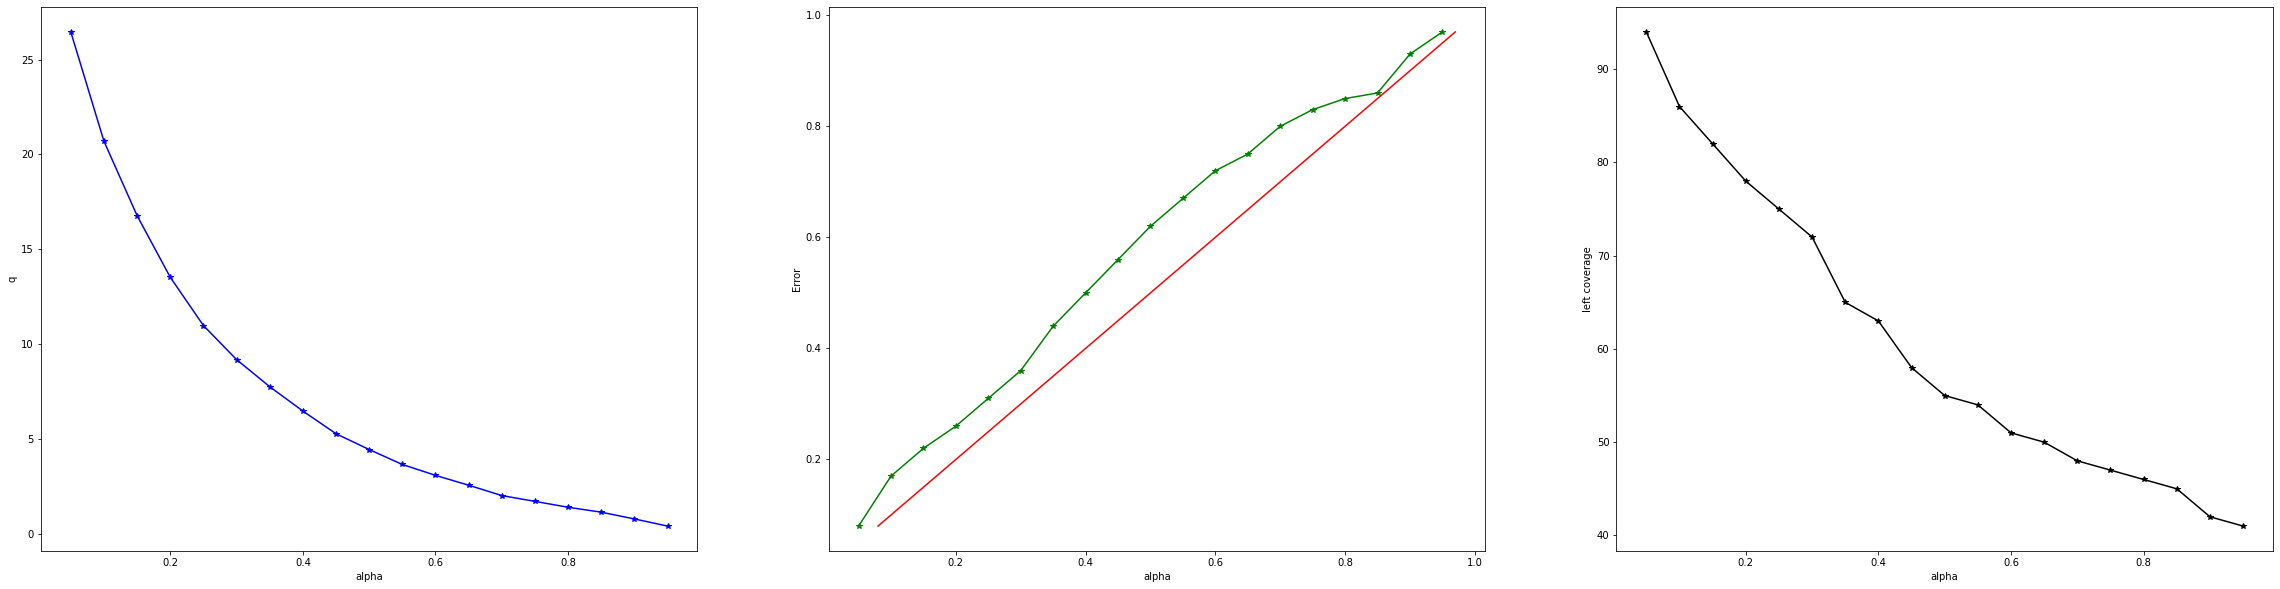

In [33]:
alpha_list = np.arange(0.05, 1, 0.05)

q_list = []
cov_list = []
left_cov_list = []
for alpha in alpha_list:

    q  = compute_quantiles(y_calib, y_hat_calib, alpha, n)
    q_list.append(q)

    left_coverage, coverage, avg_length = compute_coverage_len(y_test, y_hat_test - q, y_hat_test + q)
    cov_list.append(1 - coverage/100)
    left_cov_list.append(left_coverage)
    
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(131)
ax.plot(alpha_list, q_list, 'b-*', label='q')
plt.ylabel('q')
plt.xlabel('alpha')    

ax = fig.add_subplot(132)
ax.plot(alpha_list, cov_list, 'g-*', label='coverage')
ax.plot(cov_list, cov_list, 'r-', label='coverage')
plt.ylabel('Error')
plt.xlabel('alpha')    

ax = fig.add_subplot(133)
ax.plot(alpha_list, left_cov_list, 'k-*', label='left coverage')
plt.ylabel('left coverage')
plt.xlabel('alpha')    

The key idea is that the coverage of conformal prediction is a random quantity. That is, if we run
conformal prediction with one calibration set and then check the coverage on an infinite number of validation
points, the coverage will not converge to a fixed value. The coverage property in (1) says that coverage will
be at least 1 − α on average over the randomness in the calibration set, but with any one fixed calibration
set, the coverage on an infinite validation set will be some number that is not exactly 1 − α. Nonetheless,
we can choose n large enough to control these fluctuations in coverage by analyzing its distribution.

In [11]:
DCNN.evaluate(X_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 201.9484 - root_mean_squared_error: 14.2109


[201.9483642578125, 14.210853576660156]

In [12]:
q

20.69384867120891

0

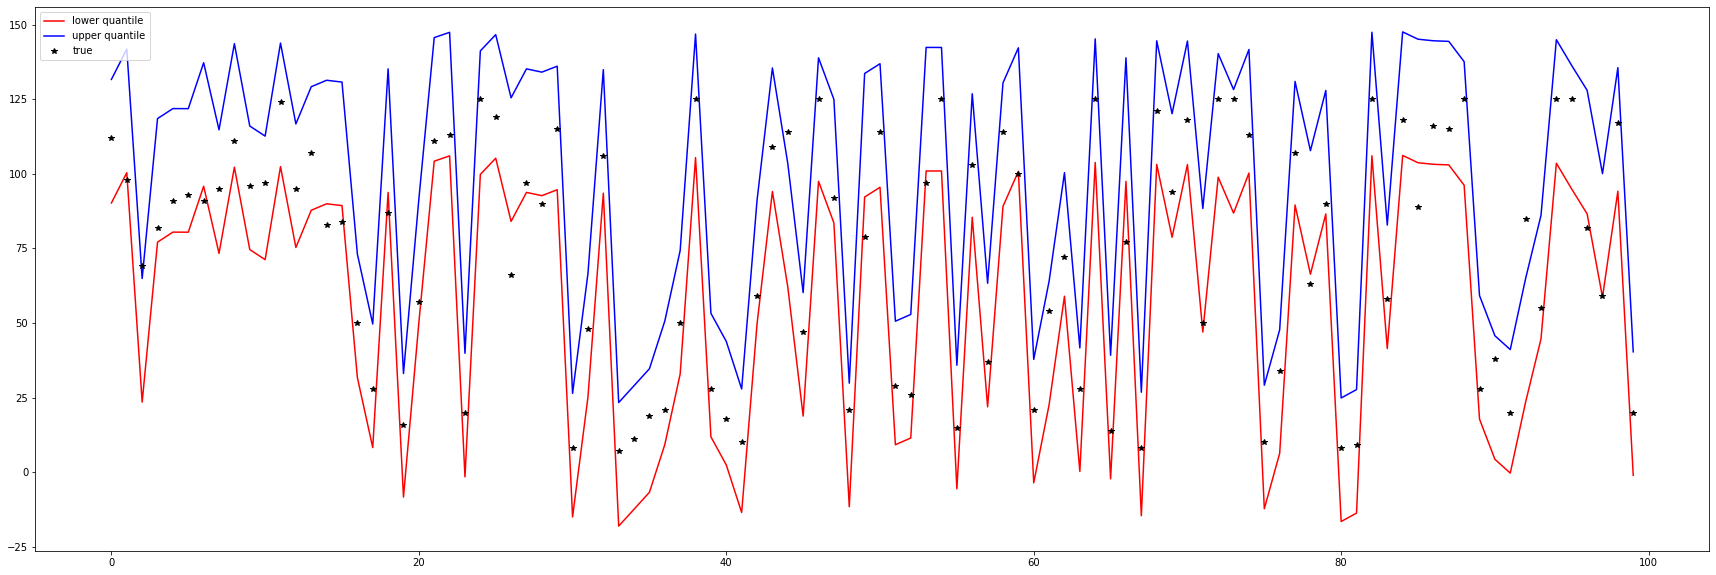

In [19]:
plot_quantiles(y_test, y_hat_test - q, y_hat_test + q)

In [14]:
print(f"Coverage is supposed to be {(1-alpha)*100}%, while it is {coverage}.")
print(f"avg length is supposed to be {2*q}, while it is {avg_length}.")

Coverage is supposed to be 90.0%, while it is 83.0.
avg length is supposed to be 41.38769734241782, while it is 41.3876953125.


In [15]:
DCNN.evaluate(X_test, y_test - q)

4/4 [==============================] - 0s 5ms/step - loss: 828.6324 - root_mean_squared_error: 28.7860


[828.6324462890625, 28.78597640991211]

In [16]:
DCNN.evaluate(X_test, y_test + q)

4/4 [==============================] - 0s 5ms/step - loss: 431.7350 - root_mean_squared_error: 20.7782


[431.7349548339844, 20.77823257446289]

In [17]:
left_coverage

86.0

# Multiple Quantile DCNNs 

In [28]:
quantiles = [0.1, 0.5, 0.9]
MQDCNN = create_MQDCNN(quantiles=quantiles, window_size=30, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
MQDCNN.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 30, 14, 1)]  0           []                               
                                                                                                  
 conv2d_65 (Conv2D)             (None, 30, 14, 10)   110         ['input_14[0][0]']               
                                                                                                  
 conv2d_66 (Conv2D)             (None, 30, 14, 10)   1010        ['conv2d_65[0][0]']              
                                                                                                  
 conv2d_67 (Conv2D)             (None, 30, 14, 10)   1010        ['conv2d_66[0][0]']              
                                                                                           

In [29]:
epochs = 50
optimizer = Adam(learning_rate=1e-3)
loss_func = MultiQuantileLoss(quantiles=quantiles)
MQDCNN.compile(optimizer=optimizer, loss=loss_func, metrics=[RootMeanSquaredError()])
MQDCNN.fit(x=X, y=y, batch_size = 512, epochs = epochs)
MQDCNN.evaluate(X_test, y_test)

Epoch 1/50
35/35 [==============================] - 7s 177ms/step - loss: 112.6322 - q0_loss: 8.0691 - q1_loss: 38.9242 - q2_loss: 65.6389 - q0_root_mean_squared_error: 91.4232 - q1_root_mean_squared_error: 88.7873 - q2_root_mean_squared_error: 84.0336
Epoch 2/50
35/35 [==============================] - 6s 180ms/step - loss: 104.8222 - q0_loss: 7.7716 - q1_loss: 36.8384 - q2_loss: 60.2122 - q0_root_mean_squared_error: 88.1329 - q1_root_mean_squared_error: 85.0574 - q2_root_mean_squared_error: 79.0080
Epoch 3/50
35/35 [==============================] - 6s 178ms/step - loss: 100.0263 - q0_loss: 7.5894 - q1_loss: 35.2156 - q2_loss: 57.2213 - q0_root_mean_squared_error: 85.4416 - q1_root_mean_squared_error: 81.8815 - q2_root_mean_squared_error: 75.8976
Epoch 4/50
35/35 [==============================] - 6s 179ms/step - loss: 95.6565 - q0_loss: 7.4816 - q1_loss: 33.7484 - q2_loss: 54.4264 - q0_root_mean_squared_error: 83.2944 - q1_root_mean_squared_error: 78.9073 - q2_root_mean_squared_erro

[29.66292953491211,
 6.504999160766602,
 17.649999618530273,
 5.507932662963867,
 70.53666687011719,
 42.402793884277344,
 68.4747314453125]

# finding the optimal calib-size and alpha

Epoch 1/100
32/32 [==============================] - 8s 192ms/step - loss: 393.4209 - q0_loss: 4.1395 - q1_loss: 8.1880 - q2_loss: 12.0564 - q3_loss: 15.9814 - q4_loss: 20.0296 - q5_loss: 58.2934 - q6_loss: 63.0930 - q7_loss: 67.7523 - q8_loss: 69.3746 - q9_loss: 74.5128 - q0_root_mean_squared_error: 93.4899 - q1_root_mean_squared_error: 92.6064 - q2_root_mean_squared_error: 91.1743 - q3_root_mean_squared_error: 90.6770 - q4_root_mean_squared_error: 90.9342 - q5_root_mean_squared_error: 88.7155 - q6_root_mean_squared_error: 89.7699 - q7_root_mean_squared_error: 90.6069 - q8_root_mean_squared_error: 88.1508 - q9_root_mean_squared_error: 89.3776
Epoch 2/100
32/32 [==============================] - 5s 157ms/step - loss: 368.7305 - q0_loss: 4.0303 - q1_loss: 7.9036 - q2_loss: 11.5520 - q3_loss: 15.2138 - q4_loss: 19.0515 - q5_loss: 54.2282 - q6_loss: 58.9636 - q7_loss: 64.0323 - q8_loss: 64.0991 - q9_loss: 69.6560 - q0_root_mean_squared_error: 91.1619 - q1_root_mean_squared_error: 89.6810 

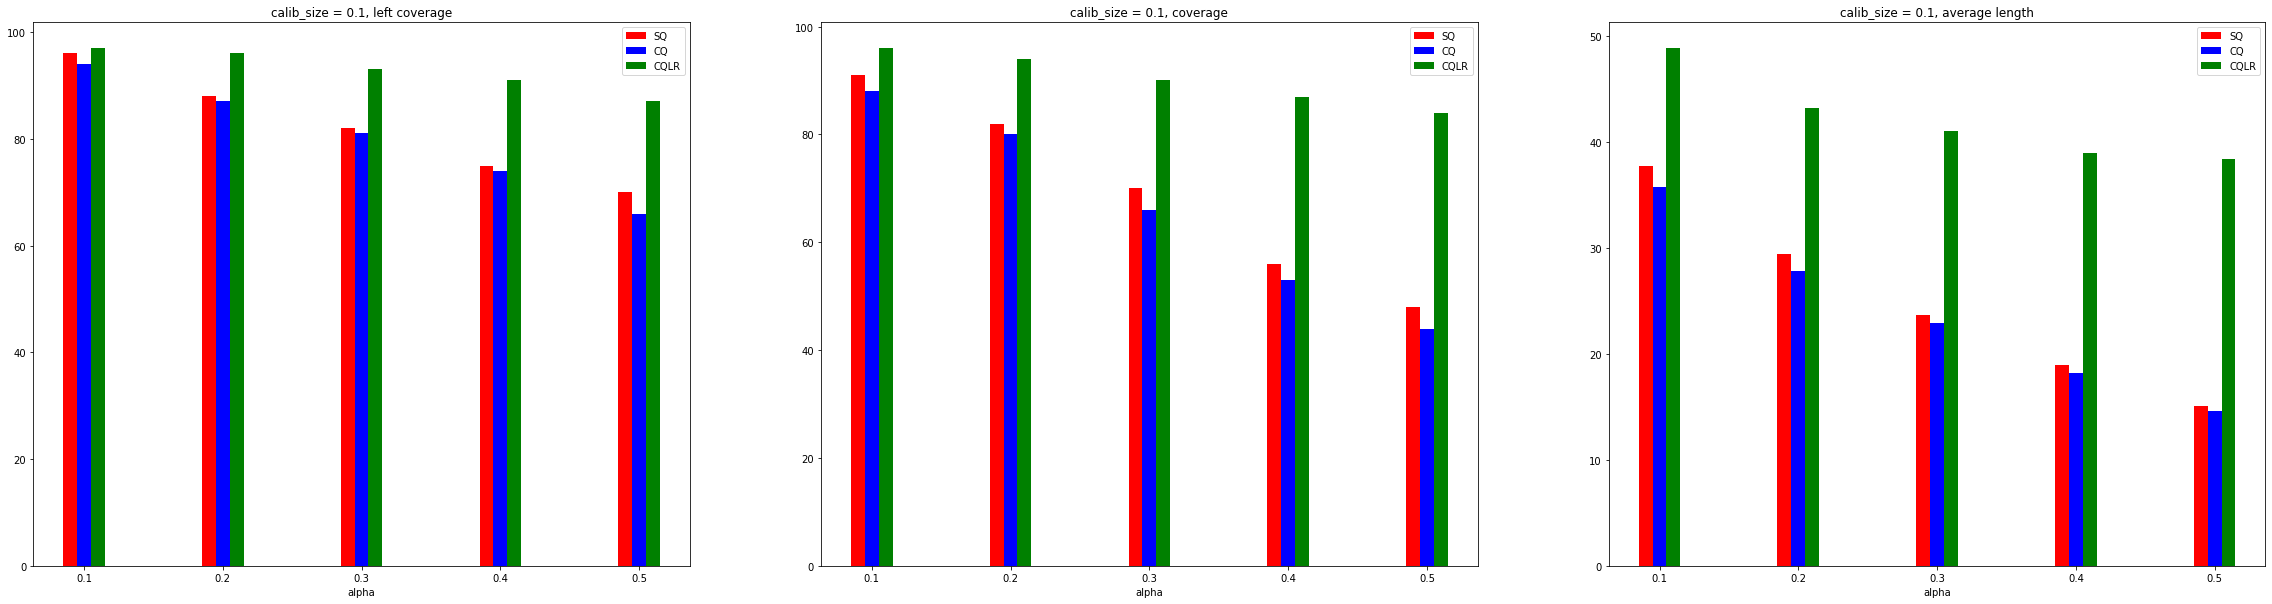

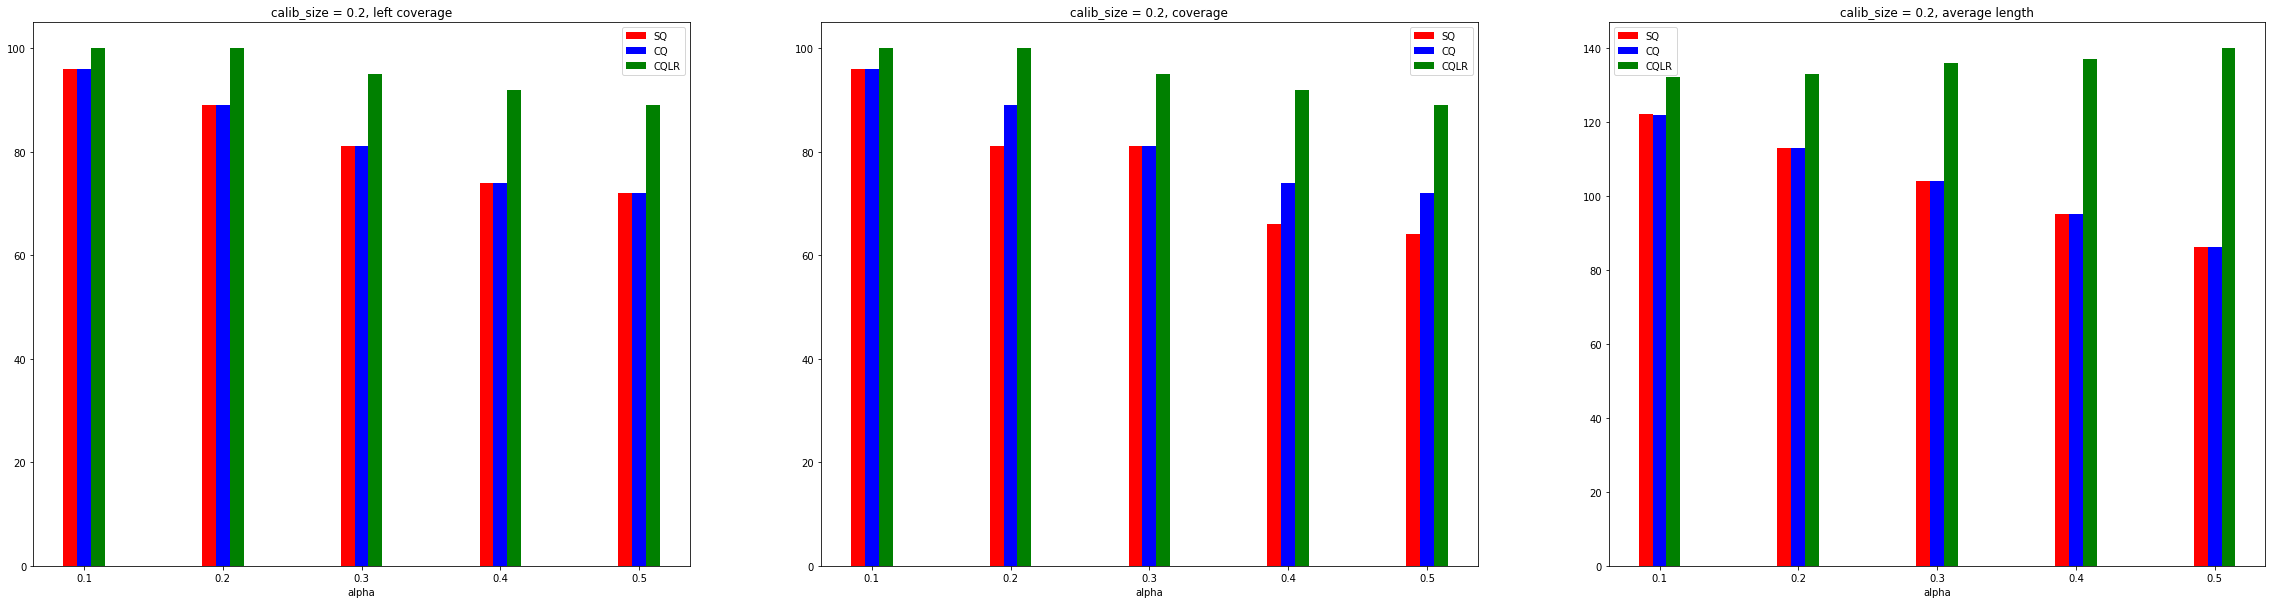

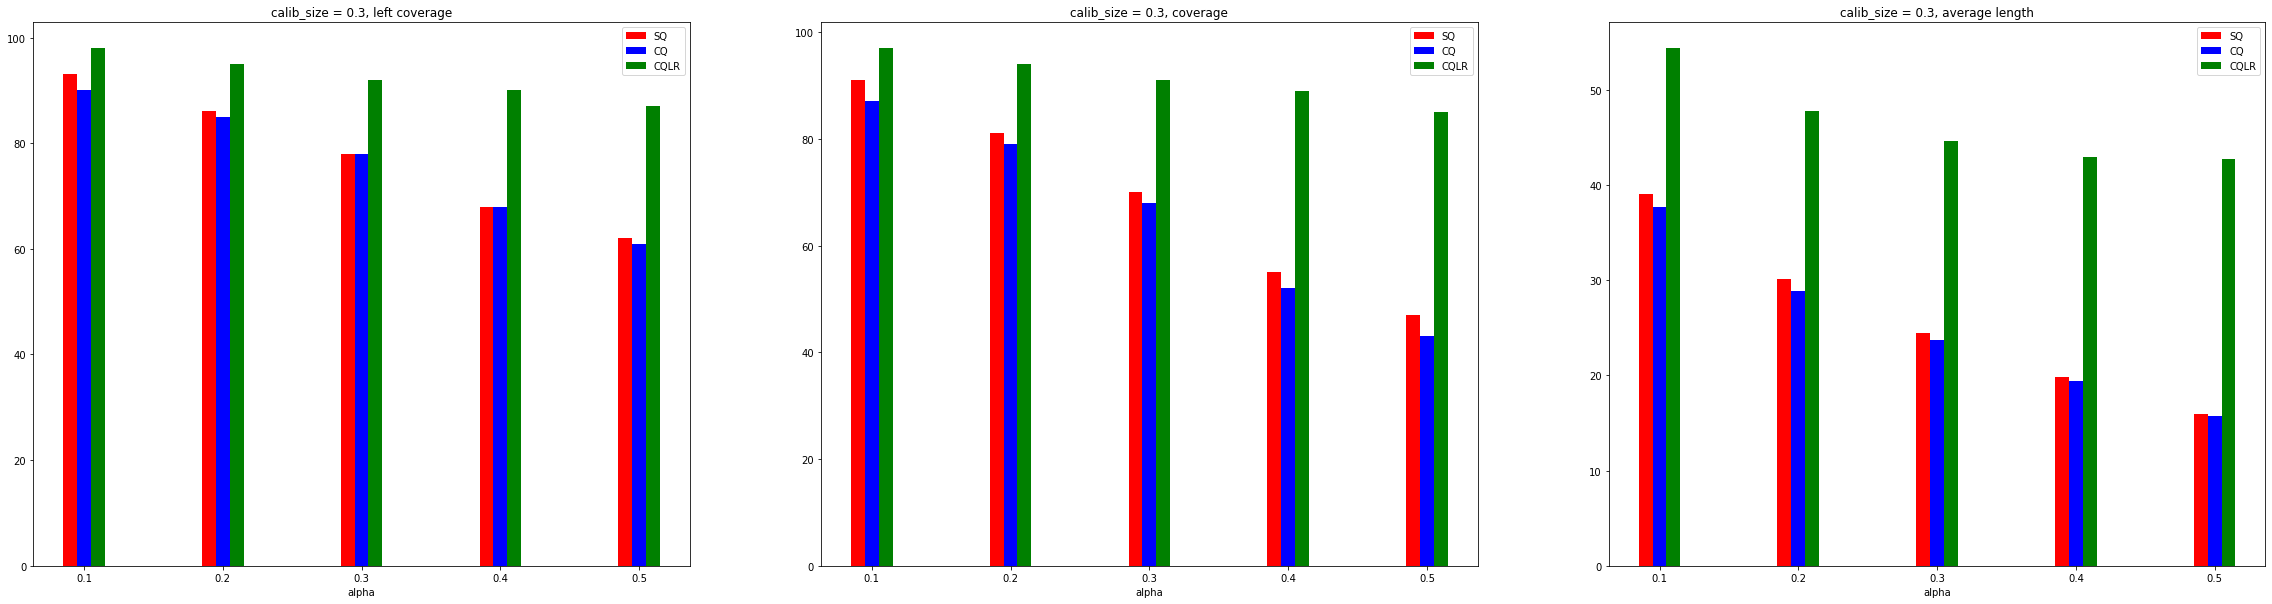

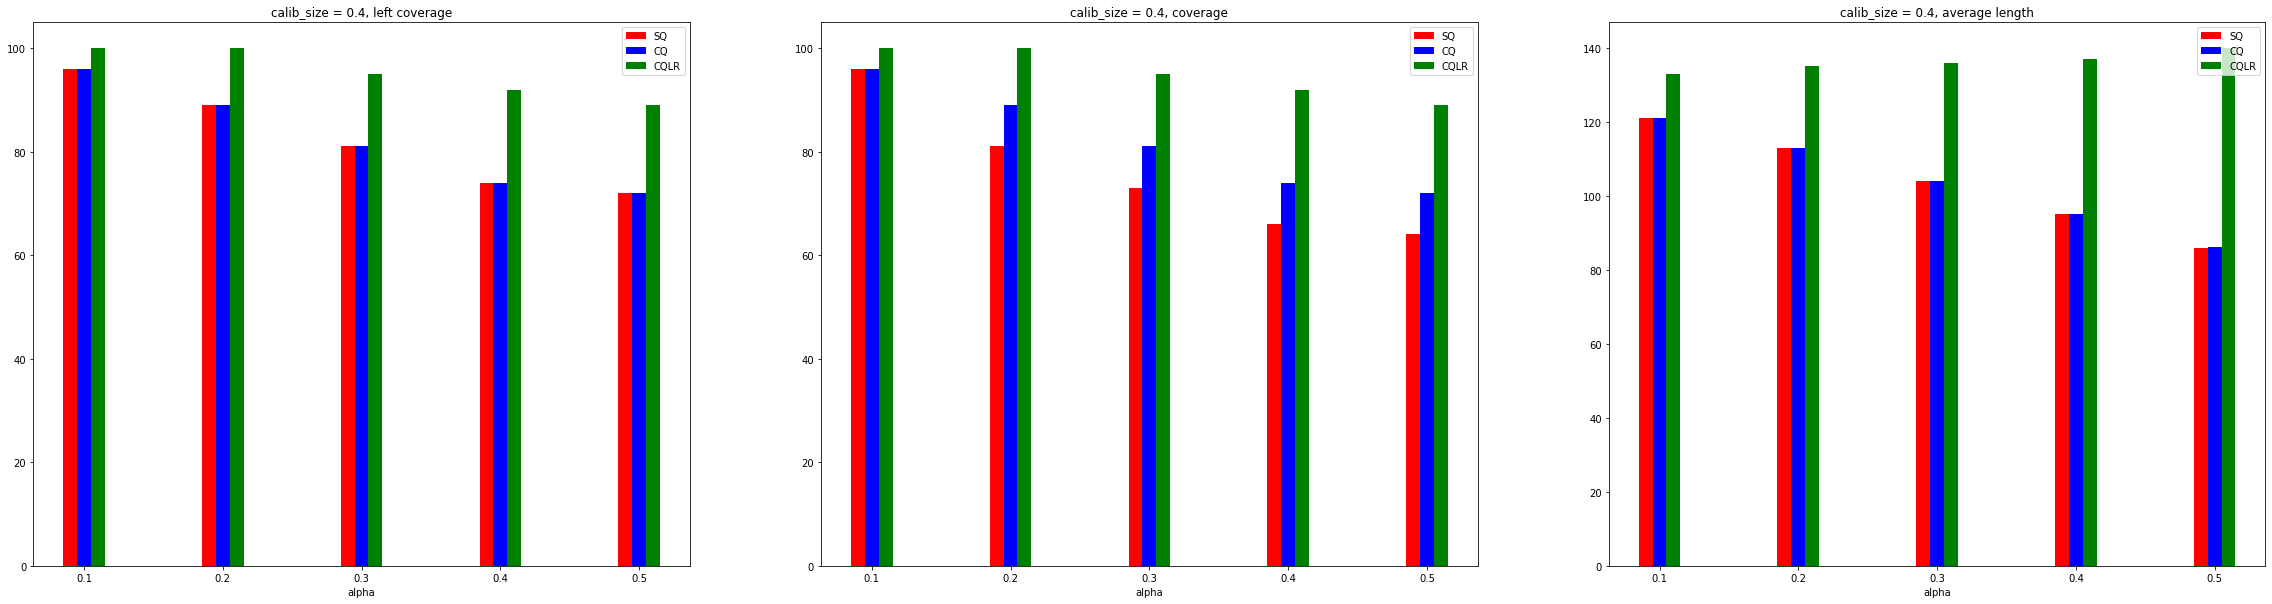

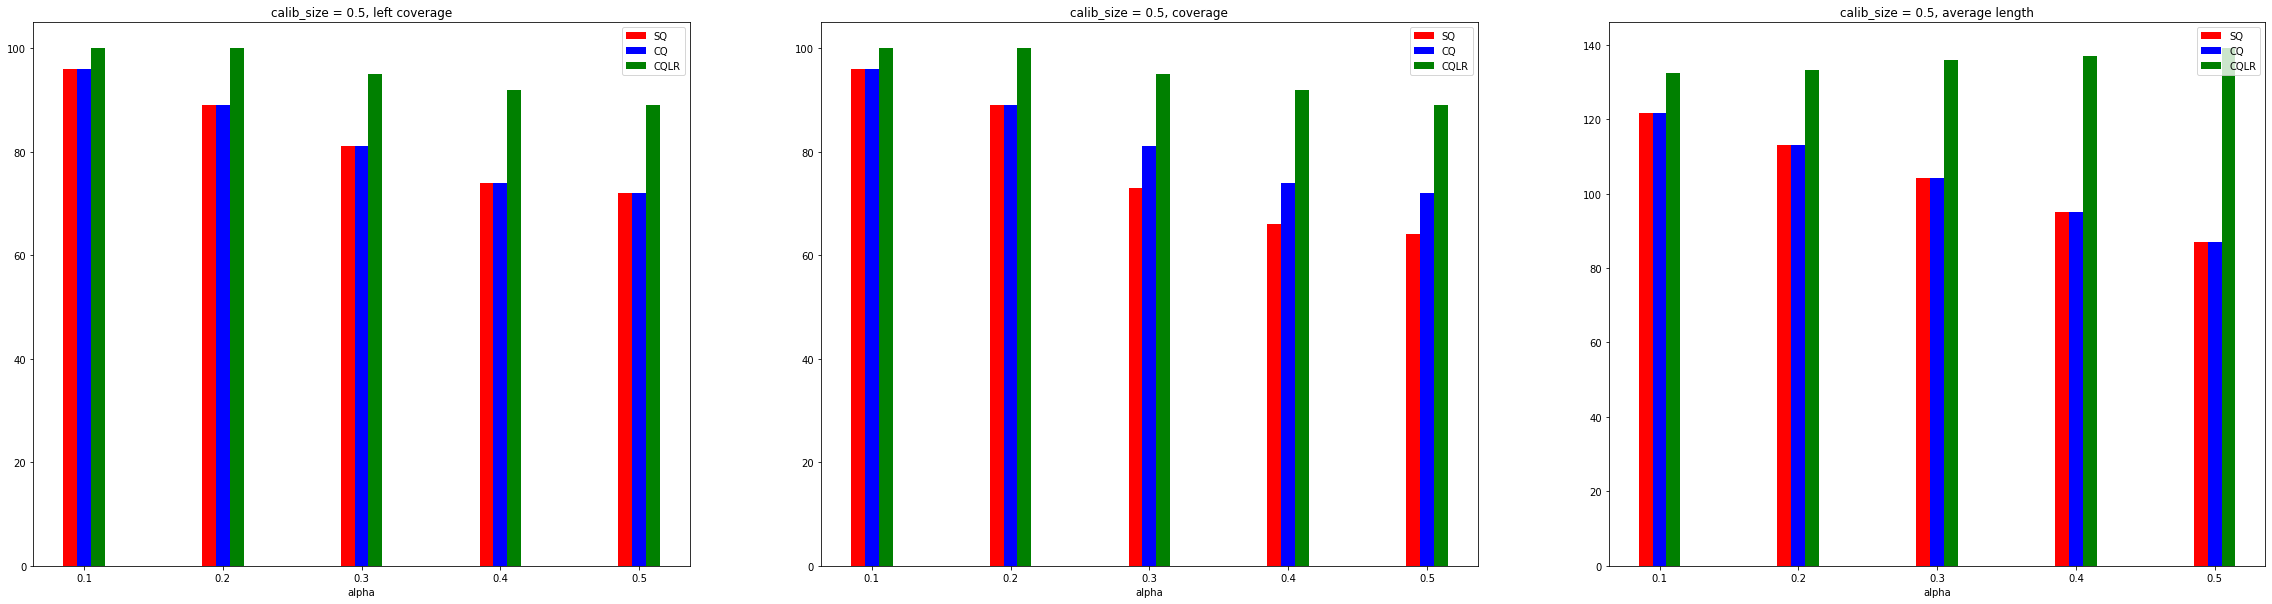

In [3]:
epochs = 100
optimizer = Adam(learning_rate=1e-3)
quantiles = [0.05, 0.1, 0.15, 0.2, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95]
loss_func = MultiQuantileLoss(quantiles=quantiles)
calib_size_list = [0.1, 0.2, 0.3, 0.4, 0.5]


models = []

for calib_size in calib_size_list:
    SQ = []
    CQ = []
    CQLR = []
    X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=calib_size, random_state=42)
    # number of calibration data
    n = X_calib.shape[0]
    MQDCNN = create_MQDCNN(quantiles=quantiles, window_size=30, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
    MQDCNN.compile(optimizer=optimizer, loss=loss_func, metrics=[RootMeanSquaredError()])
    MQDCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)
    models.append(MQDCNN)
    y_hat_calib = MQDCNN.predict(X_calib)
    y_hat_test = MQDCNN.predict(X_test)

    for i in range(len(quantiles[:5])):
        
        y_calib_lower = y_hat_calib[i]
        y_calib_upper= y_hat_calib[-i-1]
        y_test_lower = y_hat_test[i]
        y_test_upper= y_hat_test[-i-1]

        alpha = quantiles[i]*2
        alpha_low = alpha/5
        alpha_high = alpha - alpha_low
        q, q_low, q_high = compute_quantiles(y_calib, y_calib_lower, y_calib_upper, alpha,
         n, indep=True, alpha_low=alpha_low, alpha_high=alpha_high)

        SQ.append(compute_coverage_len(y_test, y_test_lower, y_test_upper))
        CQ.append(compute_coverage_len(y_test, y_test_lower - q, y_test_upper + q))
        CQLR.append(compute_coverage_len(y_test, y_test_lower - q_low, y_test_upper + q_low))


    SQ_left_coverage, SQ_coverage, SQ_avg_length = zip(*SQ)
    CQ_left_coverage, CQ_coverage, CQ_avg_length = zip(*CQ)
    CQLR_left_coverage, CQLR_coverage, CQLR_avg_length = zip(*CQLR)

    width = 0.01

    fig = plt.figure(figsize=(40, 10))
    ax = fig.add_subplot(131)
    ax.bar(np.array(quantiles[:5])*2 - width, SQ_left_coverage, color = 'r', width = width, label = 'SQ')
    ax.bar(np.array(quantiles[:5])*2, CQ_left_coverage, color = 'b', width = width, label = 'CQ')
    ax.bar(np.array(quantiles[:5])*2 + width, CQLR_left_coverage, color = 'g', width = width, label = 'CQLR')
    ax.legend()
    plt.title(f'calib_size = {calib_size}, left coverage')
    plt.xlabel('alpha')

    ax = fig.add_subplot(132)
    ax.bar(np.array(quantiles[:5])*2 - width, SQ_coverage, color = 'r', width = width, label = 'SQ')
    ax.bar(np.array(quantiles[:5])*2, CQ_coverage, color = 'b', width = width, label = 'CQ')
    ax.bar(np.array(quantiles[:5])*2 + width, CQLR_coverage, color = 'g', width = width, label = 'CQLR')
    ax.legend()
    plt.title(f'calib_size = {calib_size}, coverage')
    plt.xlabel('alpha')

    
    ax = fig.add_subplot(133)
    ax.bar(np.array(quantiles[:5])*2 - width, SQ_avg_length, color = 'r', width = width, label = 'SQ')
    ax.bar(np.array(quantiles[:5])*2, CQ_avg_length, color = 'b', width = width, label = 'CQ')
    ax.bar(np.array(quantiles[:5])*2 + width, CQLR_avg_length, color = 'g', width = width, label = 'CQLR')
    ax.legend()
    plt.title(f'calib_size = {calib_size}, average length')
    plt.xlabel('alpha')

# FD002

In [2]:
dataset = data.get_dataset("CMAPSS2")
window_size = 20


scaler = MinMaxScaler(feature_range=(-1, 1))
train = pre.apply_scaling_fn(scaler.fit_transform, dataset["train"])
test = pre.apply_scaling_fn(scaler.transform, dataset["test"])
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
cmapss_op_list = ["time", "os1", "os2", "os3"]
removable_cols += cmapss_op_list
train = train.drop(removable_cols, axis=1)
test = test.drop(removable_cols, axis=1)
train = pre.dataframe_to_supervised(train, n_in=window_size-1)
test = pre.dataframe_to_supervised(test, n_in=window_size-1)


X = np.vstack(train[0])
y = np.vstack(train[1])



X_test = []
y_test = []
for i in range(len(test[0])):
    X_test.append(test[0][i][-1,:,:,:])
    y_test.append(test[1][i][-1,:])

X_test = np.array(X_test)
y_test = np.array(y_test)

A simple DCNN 

In [9]:
DCNN = create_model(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.summary()
epochs = 30
optimizer = Adam(learning_rate=1e-3)
DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X, y=y, batch_size = 512, epochs = epochs)
DCNN.evaluate(X_test, y_test)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 20, 14, 1)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 20, 14, 10)        110       
                                                                 
 conv2d_36 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_37 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_38 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_39 (Conv2D)          (None, 20, 14, 1)         31        
                                                                 
 flatten_7 (Flatten)         (None, 280)               0   

[617.0732421875, 24.840959548950195]

In [9]:
y.shape

(48819, 1)

In [21]:
quantiles = [0.5]
DCNN = create_MQDCNN(quantiles=quantiles, window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.summary()
epochs = 30
optimizer = Adam(learning_rate=1e-3)
DCNN.compile(optimizer=optimizer, loss=MultiQuantileLoss(quantiles=quantiles), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X, y=y, batch_size = 512, epochs = epochs)
DCNN.evaluate(X_test, y_test)


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 20, 14, 1)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 20, 14, 10)        110       
                                                                 
 conv2d_56 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_57 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_58 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_59 (Conv2D)          (None, 20, 14, 1)         31        
                                                                 
 flatten_11 (Flatten)        (None, 280)               0  

[12.405292510986328, 32.427677154541016]

In [23]:
DCNN.fit(x=X, y=y, batch_size = 512, epochs = 10)
DCNN.evaluate(X_test, y_test)

Epoch 1/10
96/96 [==============================] - 10s 108ms/step - loss: 11.5054 - root_mean_squared_error: 31.0803
Epoch 2/10
96/96 [==============================] - 10s 108ms/step - loss: 11.4087 - root_mean_squared_error: 30.7892
Epoch 3/10
96/96 [==============================] - 10s 109ms/step - loss: 11.3730 - root_mean_squared_error: 30.7270
Epoch 4/10
96/96 [==============================] - 11s 110ms/step - loss: 11.3160 - root_mean_squared_error: 30.5517
Epoch 5/10
96/96 [==============================] - 11s 111ms/step - loss: 11.4179 - root_mean_squared_error: 30.8600
Epoch 6/10
96/96 [==============================] - 11s 110ms/step - loss: 11.2786 - root_mean_squared_error: 30.5668
Epoch 7/10
96/96 [==============================] - 12s 121ms/step - loss: 11.3434 - root_mean_squared_error: 30.7566
Epoch 8/10
96/96 [==============================] - 12s 121ms/step - loss: 11.2999 - root_mean_squared_error: 30.6862
Epoch 9/10
96/96 [==============================] - 11s 

[9.173078536987305, 24.29029083251953]

In [26]:
quantiles = [0.95]
DCNN = create_MQDCNN(quantiles=quantiles, window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.summary()
epochs = 30
optimizer = Adam(learning_rate=1e-3)
DCNN.compile(optimizer=optimizer, loss=MultiQuantileLoss(quantiles=quantiles), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X, y=y, batch_size = 512, epochs = epochs)
DCNN.evaluate(X_test, y_test)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 20, 14, 1)]       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 20, 14, 10)        110       
                                                                 
 conv2d_61 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_62 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_63 (Conv2D)          (None, 20, 14, 10)        1010      
                                                                 
 conv2d_64 (Conv2D)          (None, 20, 14, 1)         31        
                                                                 
 flatten_12 (Flatten)        (None, 280)               0  

[2.7621078491210938, 70.77710723876953]

# Let the magic begin

Epoch 1/50
86/86 [==============================] - 18s 173ms/step - loss: 388.6275 - q0_loss: 4.0667 - q1_loss: 8.1271 - q2_loss: 12.2661 - q3_loss: 15.9802 - q4_loss: 20.0311 - q5_loss: 59.2803 - q6_loss: 61.9893 - q7_loss: 65.0738 - q8_loss: 68.6972 - q9_loss: 73.1158 - q0_root_mean_squared_error: 89.9591 - q1_root_mean_squared_error: 91.5147 - q2_root_mean_squared_error: 92.3061 - q3_root_mean_squared_error: 90.4970 - q4_root_mean_squared_error: 90.8304 - q5_root_mean_squared_error: 90.0981 - q6_root_mean_squared_error: 88.6884 - q7_root_mean_squared_error: 87.8518 - q8_root_mean_squared_error: 87.6659 - q9_root_mean_squared_error: 88.2494
Epoch 2/50
86/86 [==============================] - 14s 163ms/step - loss: 346.4376 - q0_loss: 4.0304 - q1_loss: 7.7171 - q2_loss: 11.3876 - q3_loss: 14.7216 - q4_loss: 18.2760 - q5_loss: 52.7262 - q6_loss: 54.8980 - q7_loss: 57.5038 - q8_loss: 60.5456 - q9_loss: 64.6313 - q0_root_mean_squared_error: 87.3379 - q1_root_mean_squared_error: 85.1653 

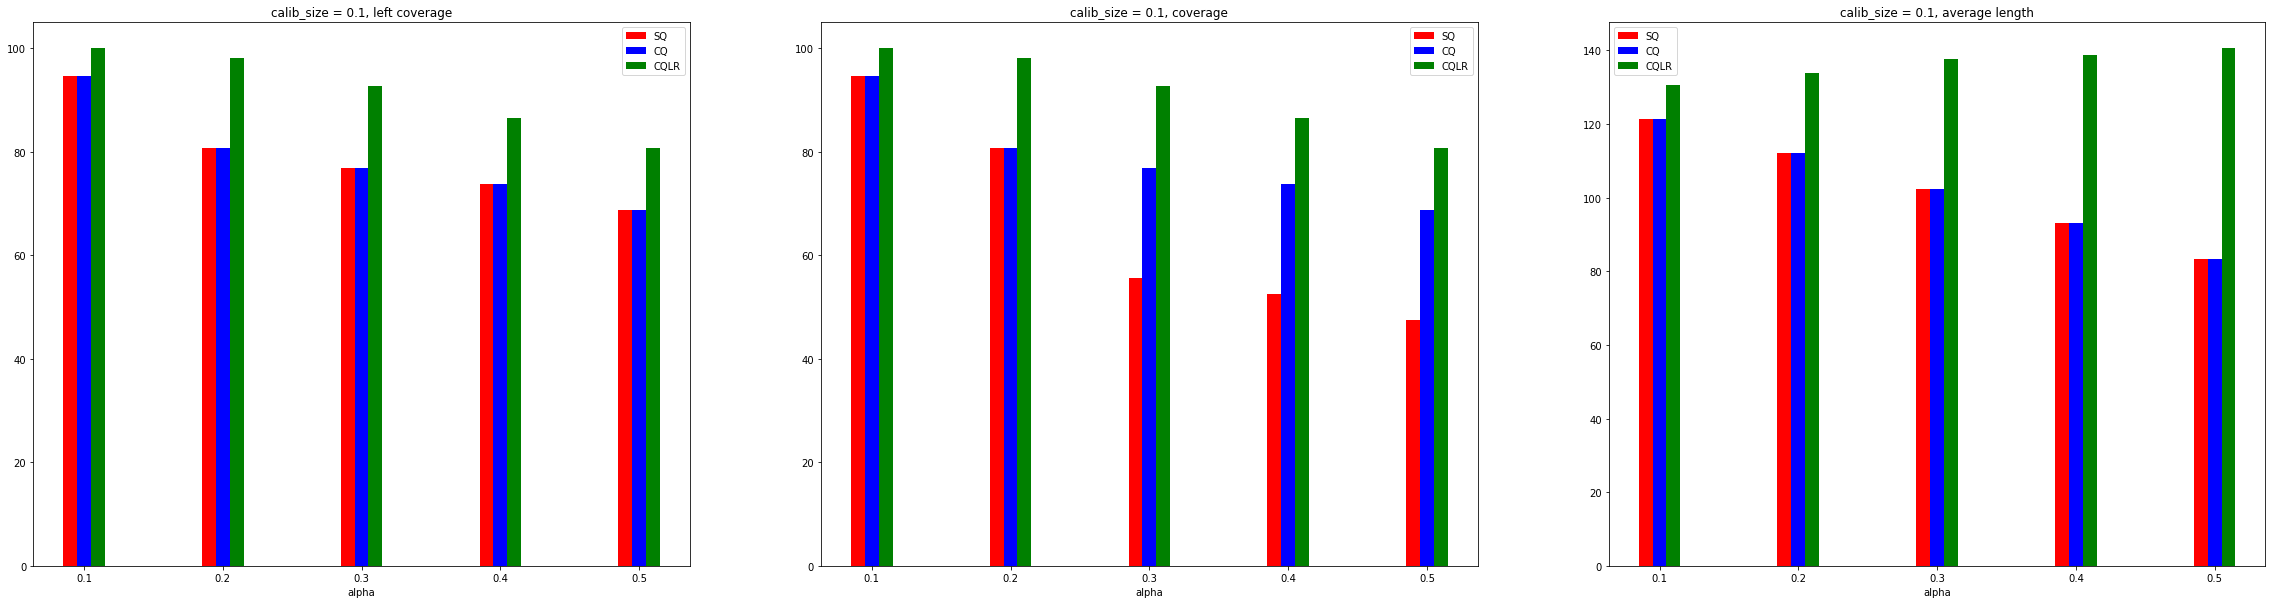

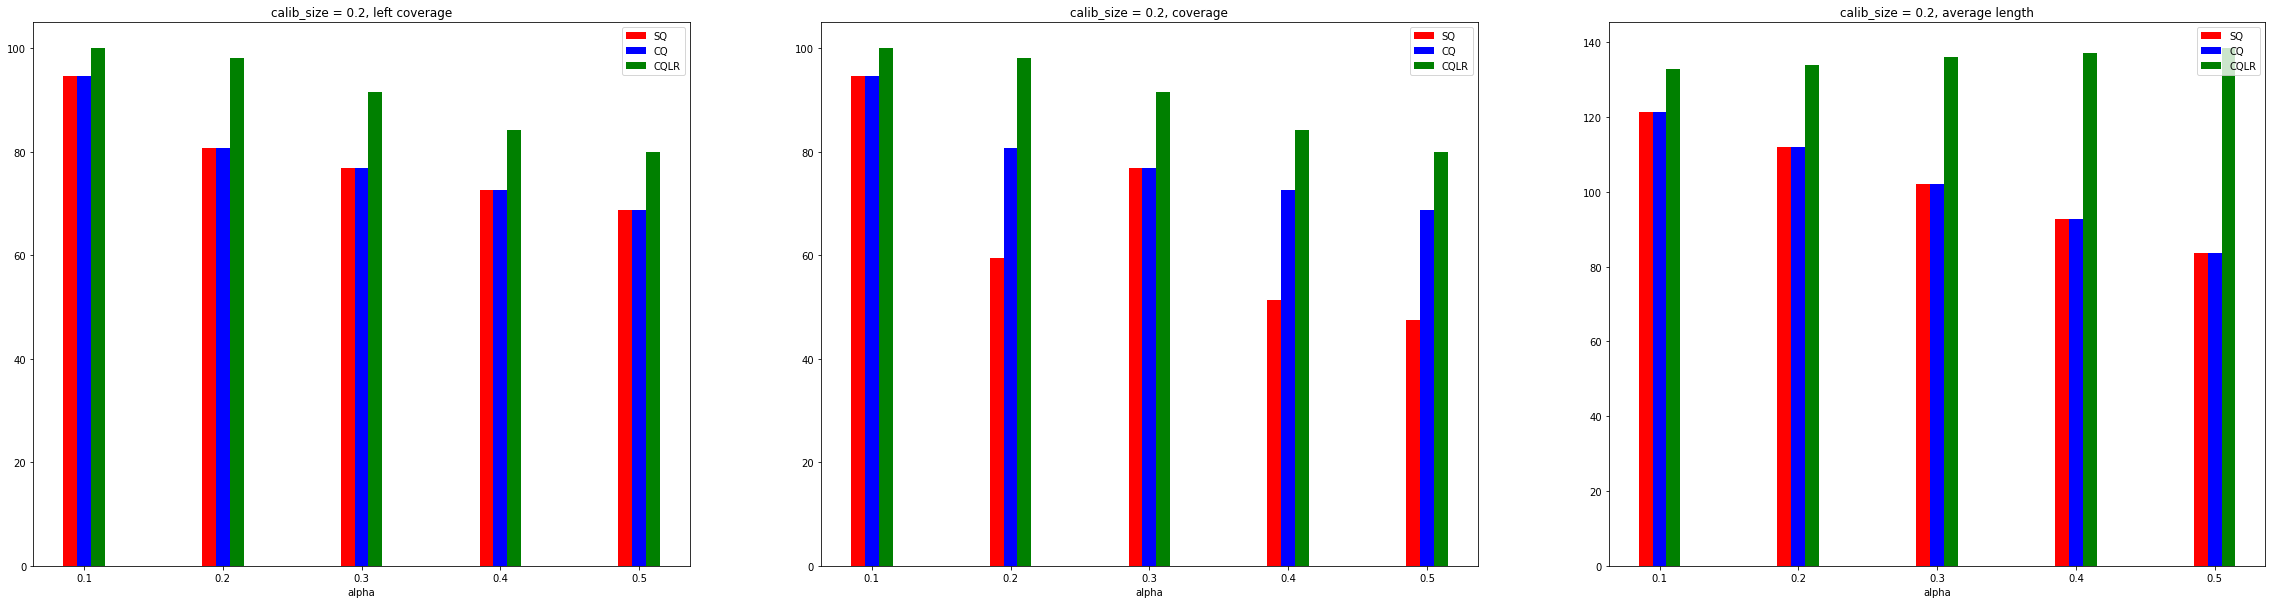

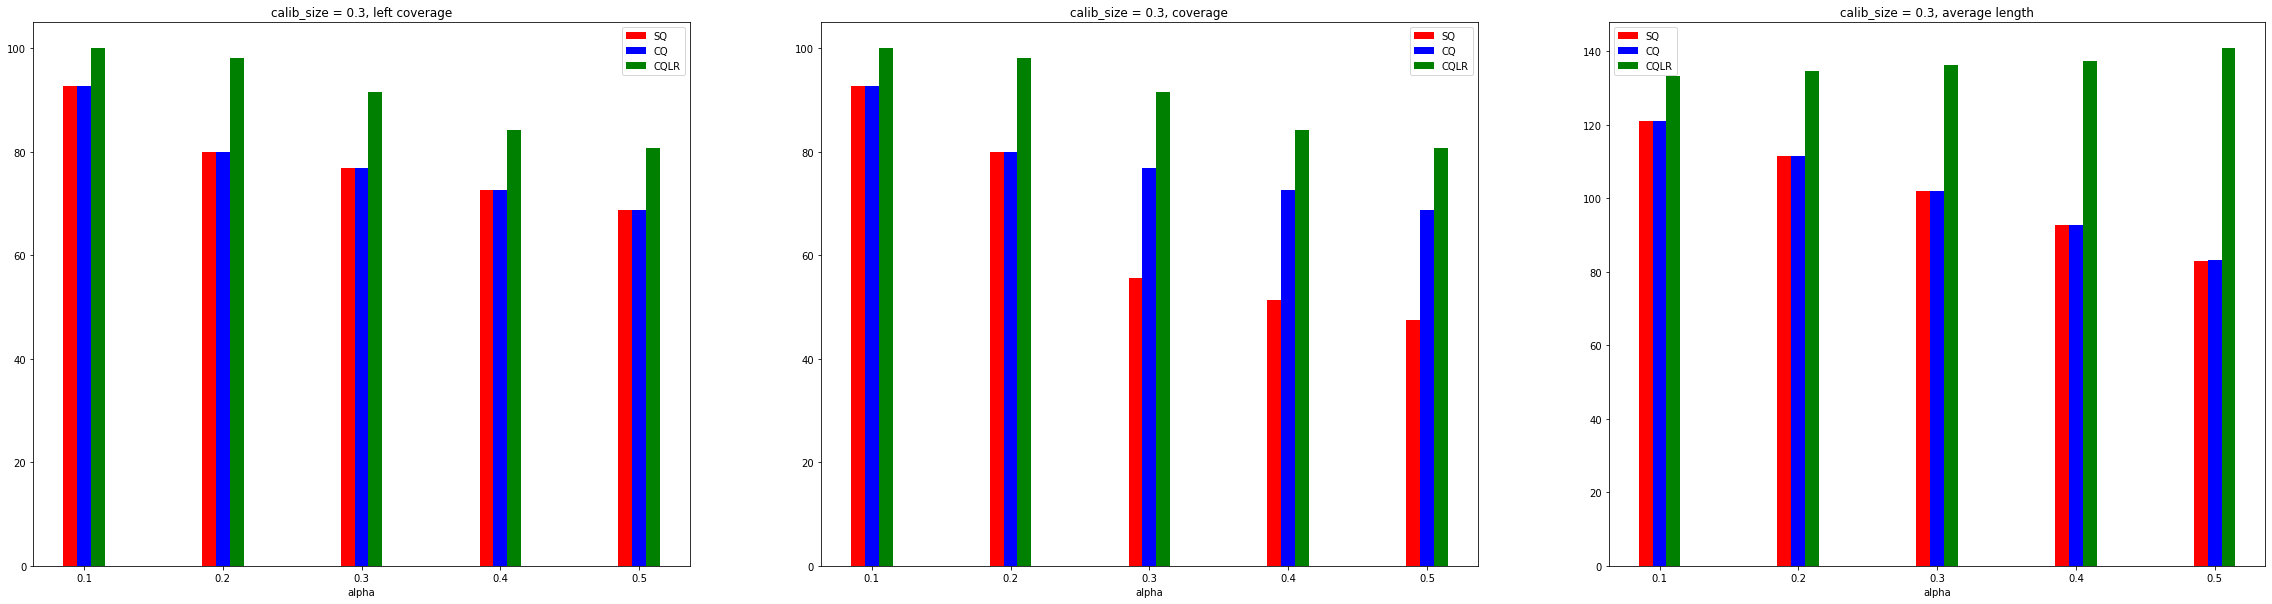

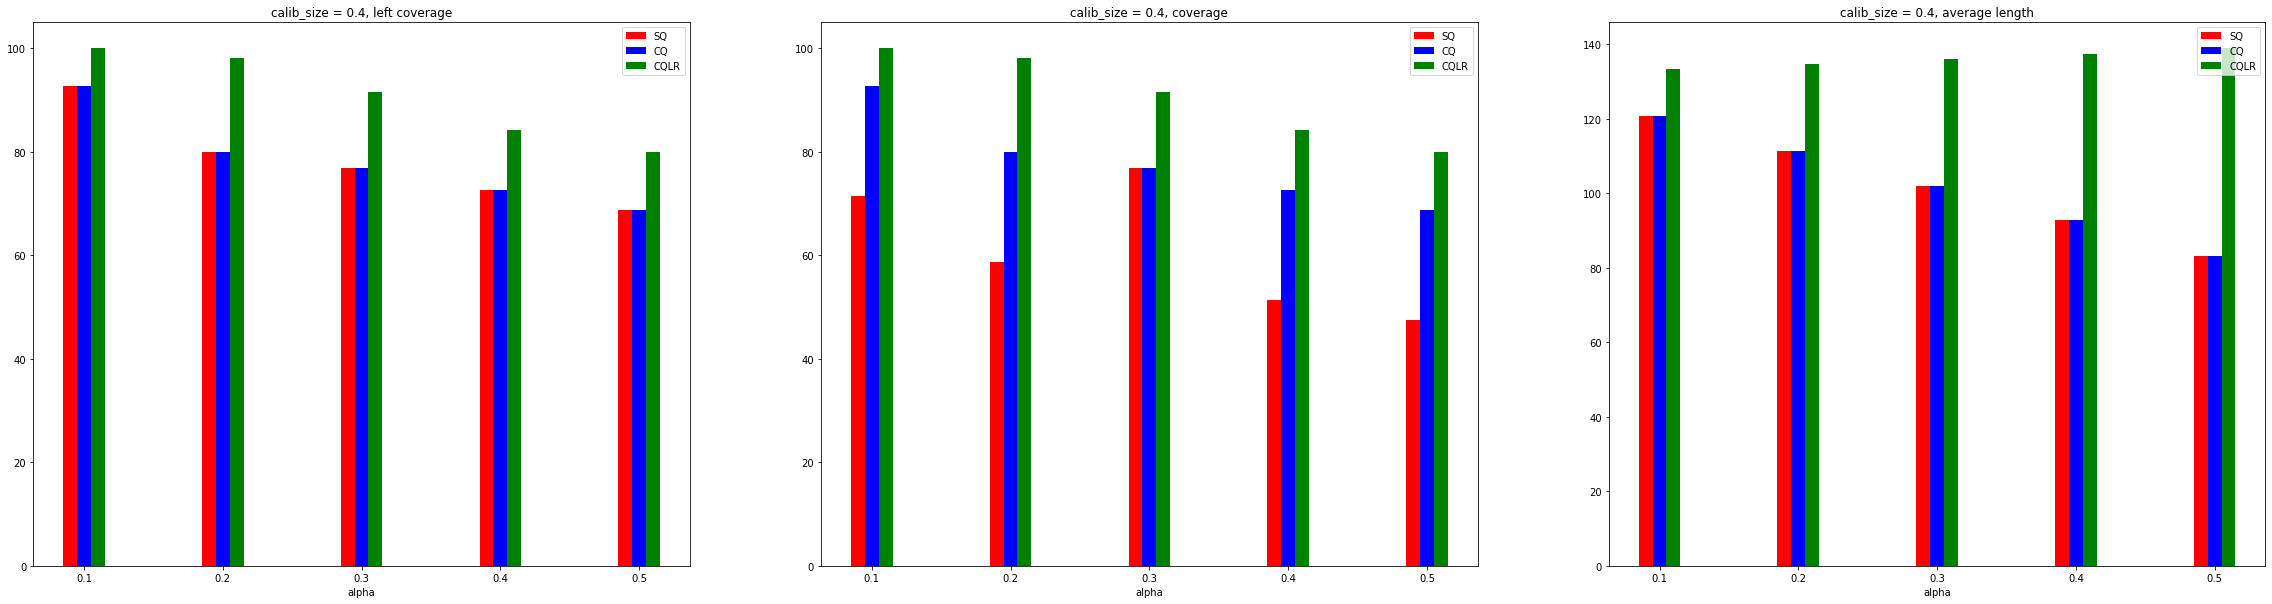

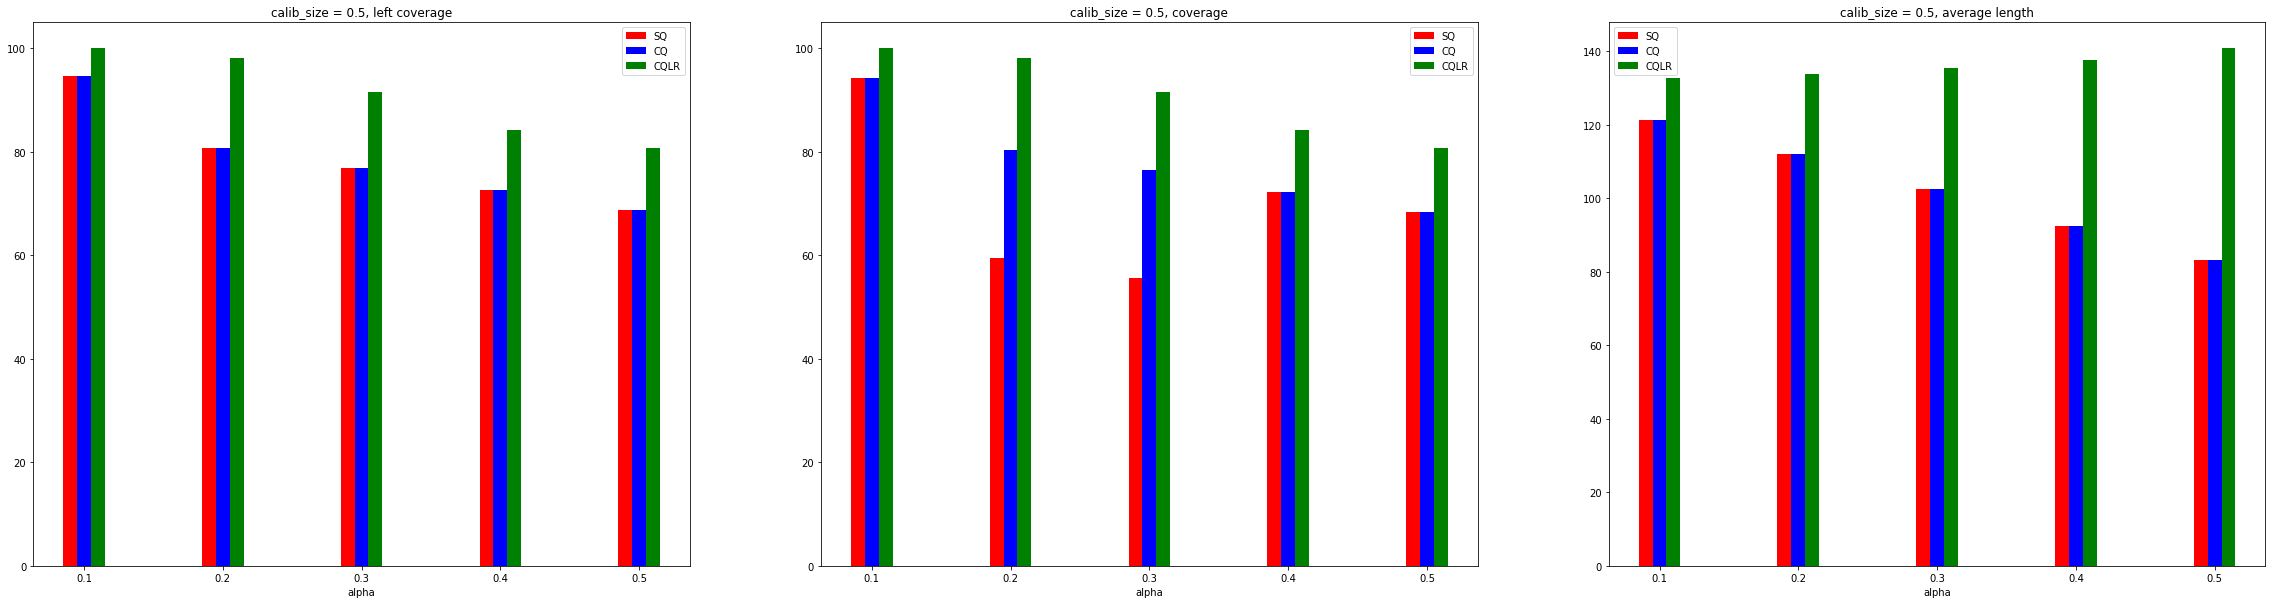

In [3]:
window_size = 20
epochs = 50
optimizer = Adam(learning_rate=1e-3)
quantiles = [0.05, 0.1, 0.15, 0.2, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95]
loss_func = MultiQuantileLoss(quantiles=quantiles)
calib_size_list = [0.1, 0.2, 0.3, 0.4, 0.5]


models = []

for calib_size in calib_size_list:
    SQ = []
    CQ = []
    CQLR = []
    X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=calib_size, random_state=42)
    # number of calibration data
    n = X_calib.shape[0]
    MQDCNN = create_MQDCNN(quantiles=quantiles, window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
    MQDCNN.compile(optimizer=optimizer, loss=loss_func, metrics=[RootMeanSquaredError()])
    MQDCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)
    models.append(MQDCNN)
    y_hat_calib = MQDCNN.predict(X_calib)
    y_hat_test = MQDCNN.predict(X_test)

    for i in range(len(quantiles[:5])):
        
        y_calib_lower = y_hat_calib[i]
        y_calib_upper= y_hat_calib[-i-1]
        y_test_lower = y_hat_test[i]
        y_test_upper= y_hat_test[-i-1]

        alpha = quantiles[i]*2
        alpha_low = alpha/5
        alpha_high = alpha - alpha_low
        q, q_low, q_high = compute_quantiles(y_calib, y_calib_lower, y_calib_upper, alpha,
         n, indep=True, alpha_low=alpha_low, alpha_high=alpha_high)

        SQ.append(compute_coverage_len(y_test, y_test_lower, y_test_upper))
        CQ.append(compute_coverage_len(y_test, y_test_lower - q, y_test_upper + q))
        CQLR.append(compute_coverage_len(y_test, y_test_lower - q_low, y_test_upper + q_low))


    SQ_left_coverage, SQ_coverage, SQ_avg_length = zip(*SQ)
    CQ_left_coverage, CQ_coverage, CQ_avg_length = zip(*CQ)
    CQLR_left_coverage, CQLR_coverage, CQLR_avg_length = zip(*CQLR)

    width = 0.01

    fig = plt.figure(figsize=(40, 10))
    ax = fig.add_subplot(131)
    ax.bar(np.array(quantiles[:5])*2 - width, SQ_left_coverage, color = 'r', width = width, label = 'SQ')
    ax.bar(np.array(quantiles[:5])*2, CQ_left_coverage, color = 'b', width = width, label = 'CQ')
    ax.bar(np.array(quantiles[:5])*2 + width, CQLR_left_coverage, color = 'g', width = width, label = 'CQLR')
    ax.legend()
    plt.title(f'calib_size = {calib_size}, left coverage')
    plt.xlabel('alpha')

    ax = fig.add_subplot(132)
    ax.bar(np.array(quantiles[:5])*2 - width, SQ_coverage, color = 'r', width = width, label = 'SQ')
    ax.bar(np.array(quantiles[:5])*2, CQ_coverage, color = 'b', width = width, label = 'CQ')
    ax.bar(np.array(quantiles[:5])*2 + width, CQLR_coverage, color = 'g', width = width, label = 'CQLR')
    ax.legend()
    plt.title(f'calib_size = {calib_size}, coverage')
    plt.xlabel('alpha')

    
    ax = fig.add_subplot(133)
    ax.bar(np.array(quantiles[:5])*2 - width, SQ_avg_length, color = 'r', width = width, label = 'SQ')
    ax.bar(np.array(quantiles[:5])*2, CQ_avg_length, color = 'b', width = width, label = 'CQ')
    ax.bar(np.array(quantiles[:5])*2 + width, CQLR_avg_length, color = 'g', width = width, label = 'CQLR')
    ax.legend()
    plt.title(f'calib_size = {calib_size}, average length')
    plt.xlabel('alpha')

# old test

Epoch 1/50
32/32 [==============================] - 6s 176ms/step - loss: 1562.0663 - root_mean_squared_error: 67.6587
Epoch 2/50
32/32 [==============================] - 6s 175ms/step - loss: 1162.8904 - root_mean_squared_error: 49.1518
Epoch 3/50
32/32 [==============================] - 5s 170ms/step - loss: 1052.1394 - root_mean_squared_error: 44.2469
Epoch 4/50
32/32 [==============================] - 6s 179ms/step - loss: 994.8001 - root_mean_squared_error: 41.0286
Epoch 5/50
32/32 [==============================] - 6s 171ms/step - loss: 979.3129 - root_mean_squared_error: 39.9555
Epoch 6/50
32/32 [==============================] - 5s 168ms/step - loss: 959.1822 - root_mean_squared_error: 39.1491
Epoch 7/50
32/32 [==============================] - 5s 159ms/step - loss: 949.1313 - root_mean_squared_error: 38.3083
Epoch 8/50
32/32 [==============================] - 5s 161ms/step - loss: 927.6748 - root_mean_squared_error: 37.1379
Epoch 9/50
32/32 [==============================] - 5

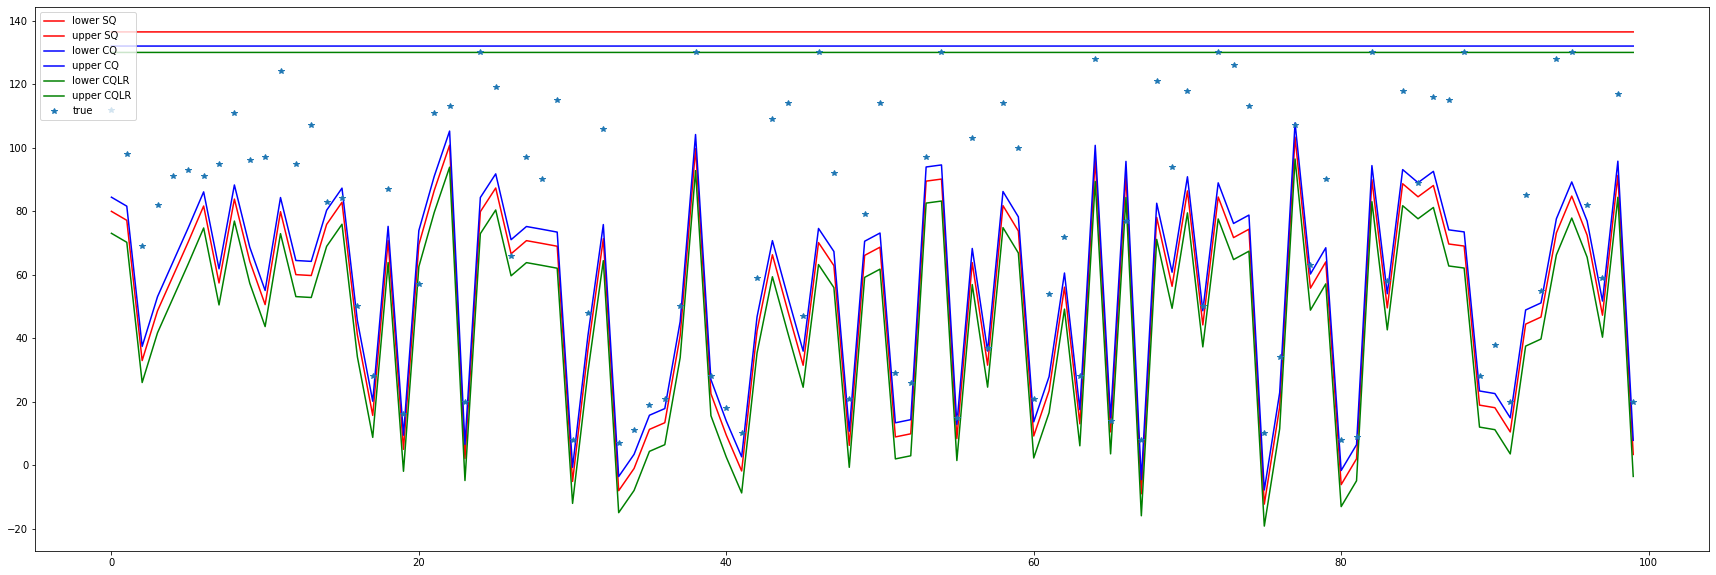

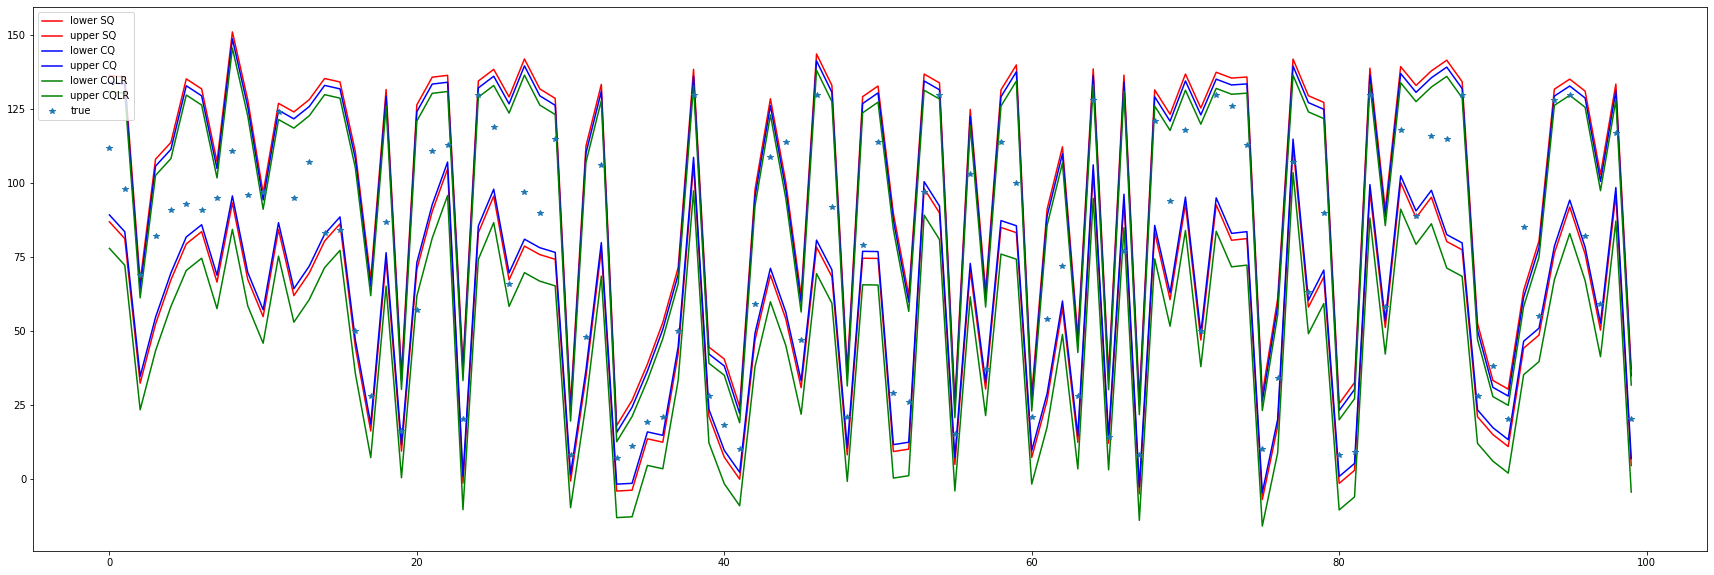

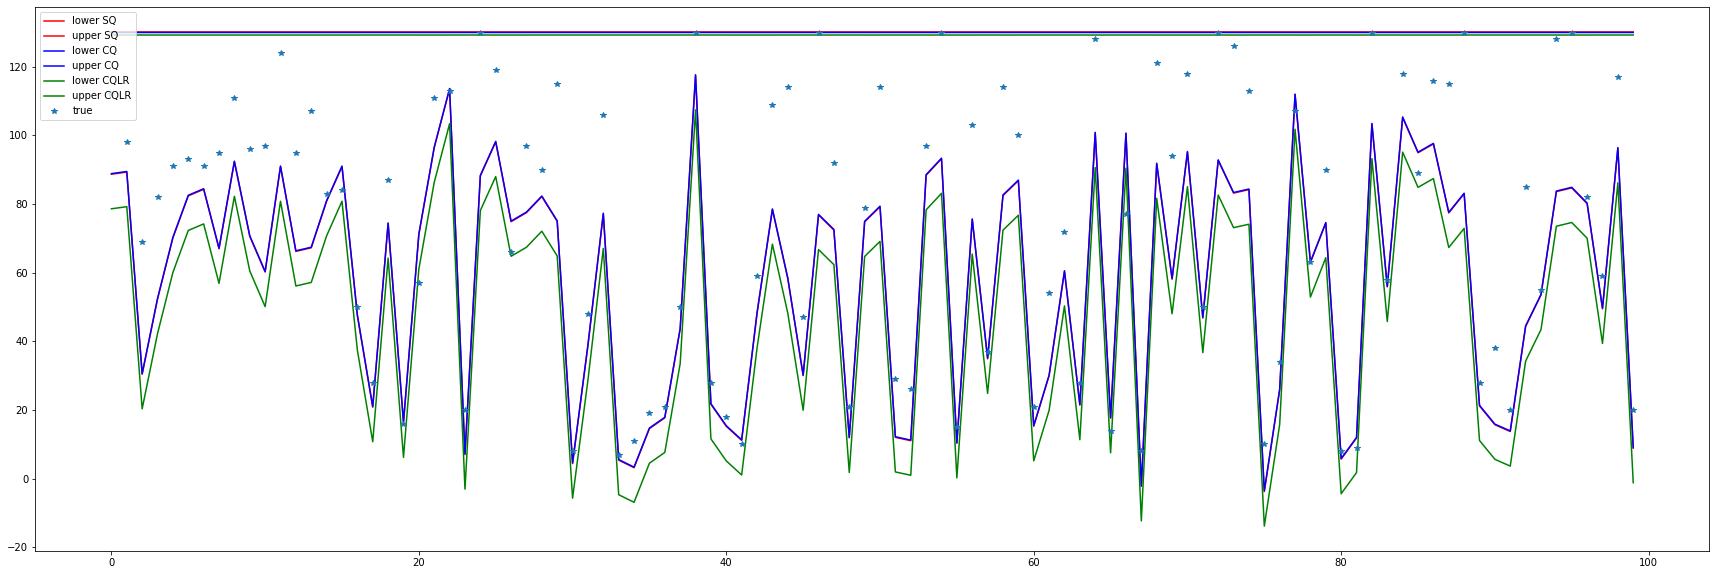

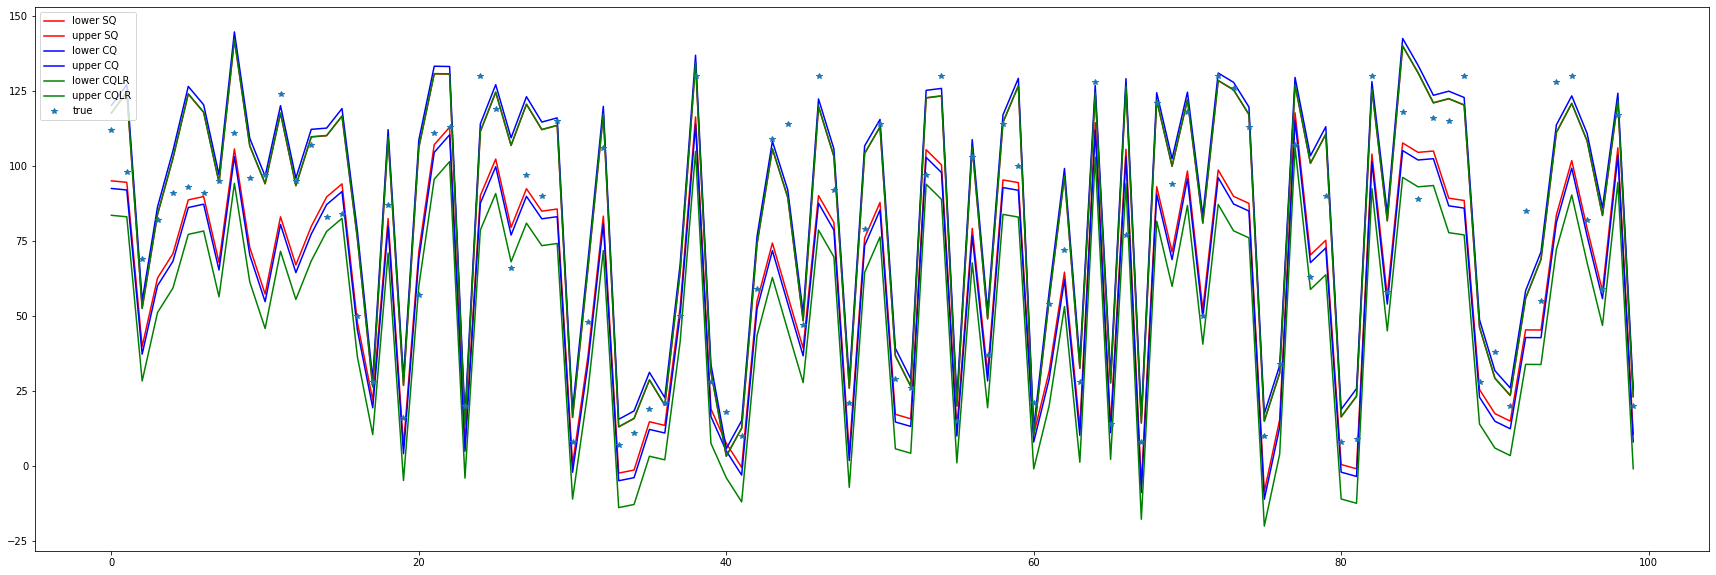

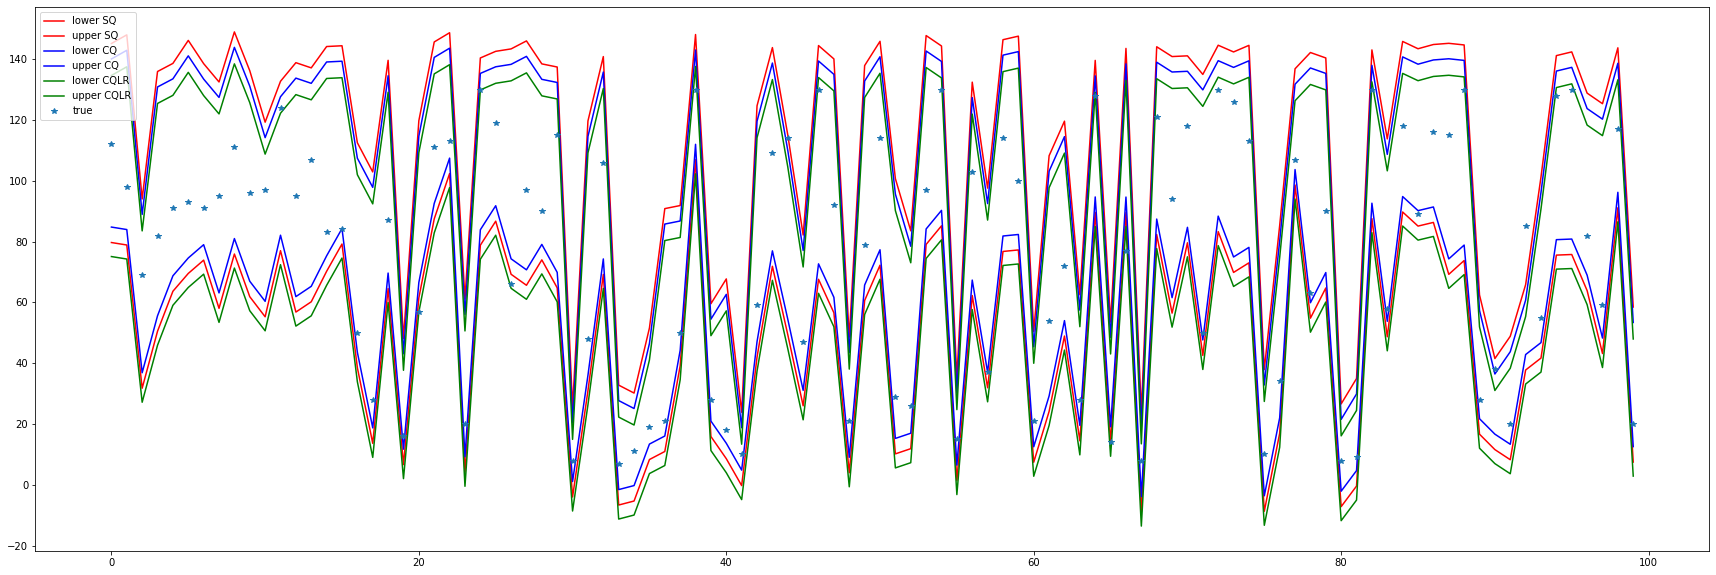

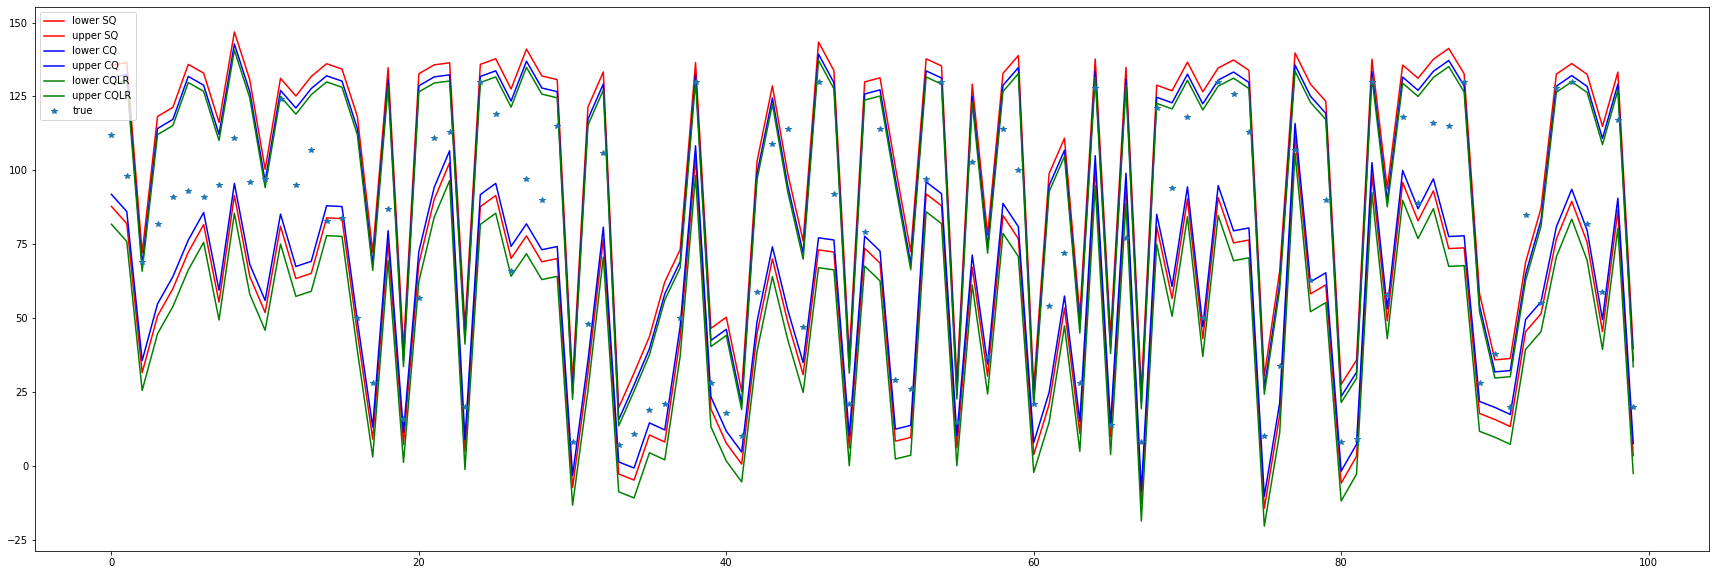

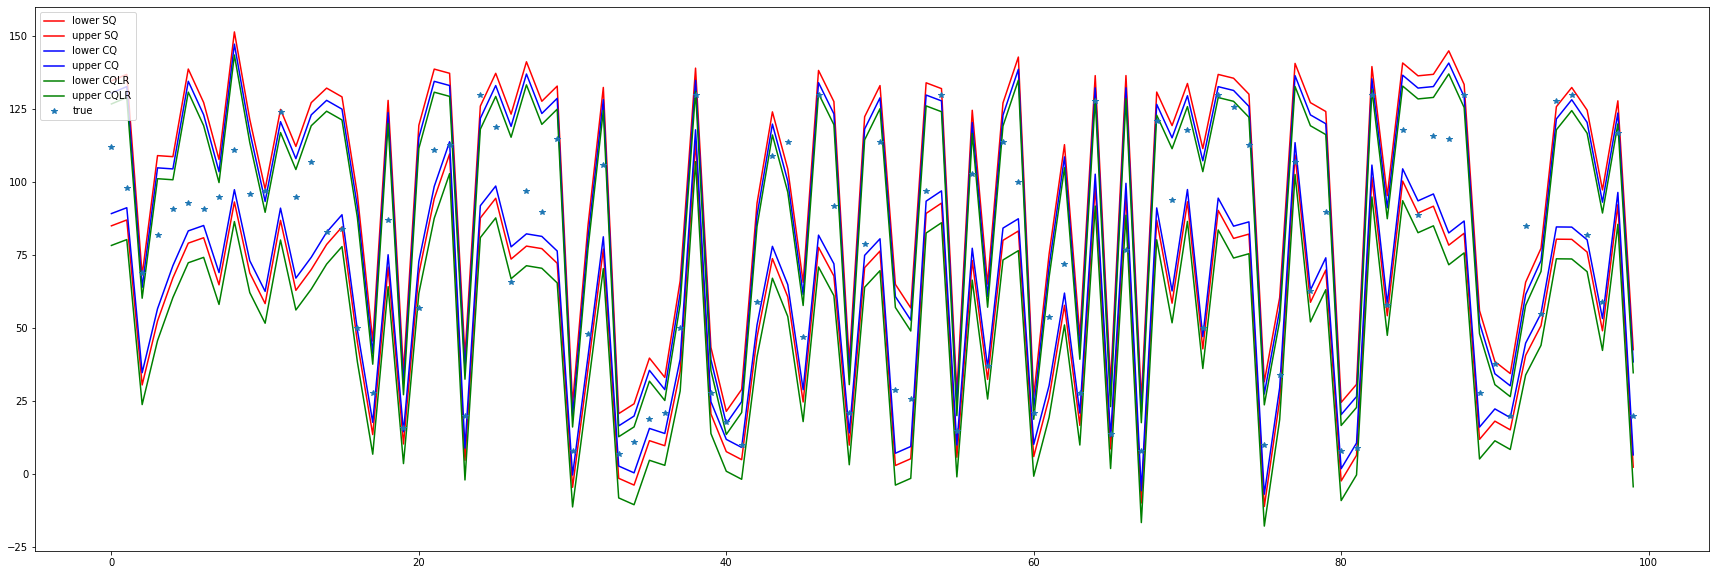

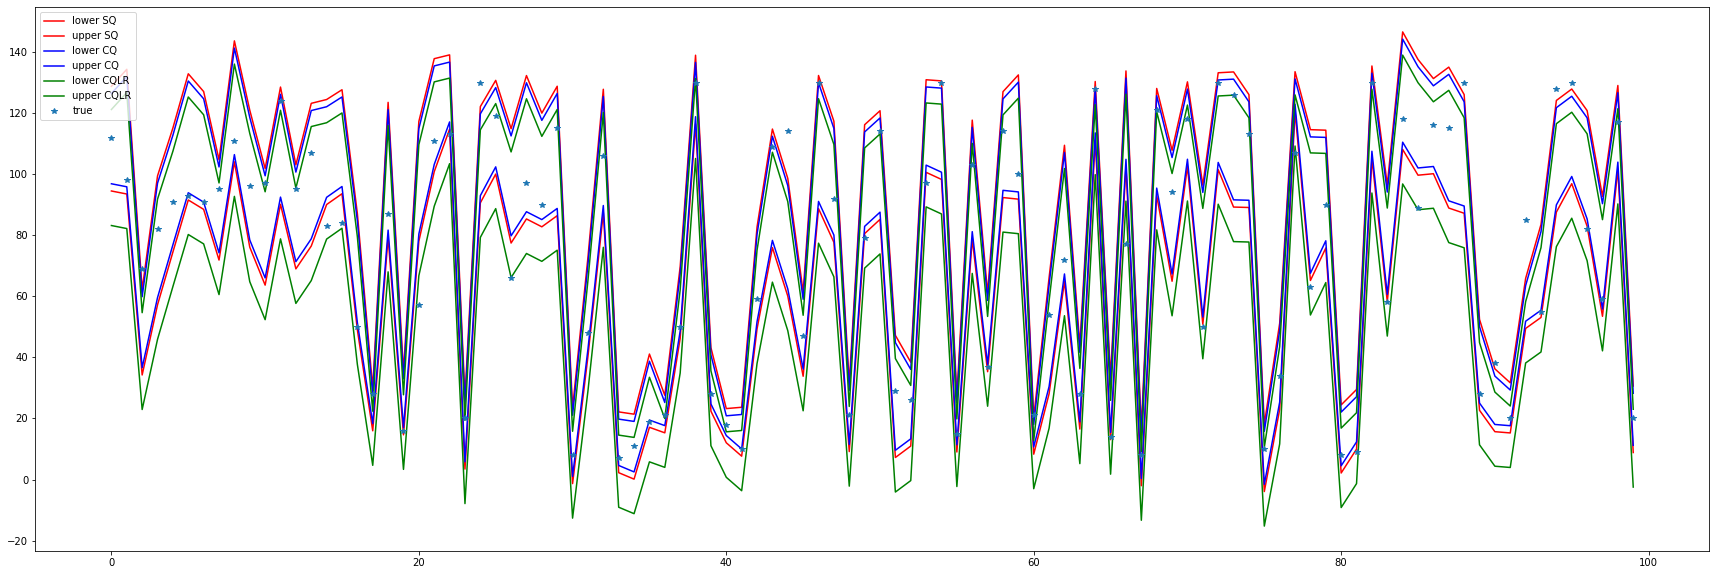

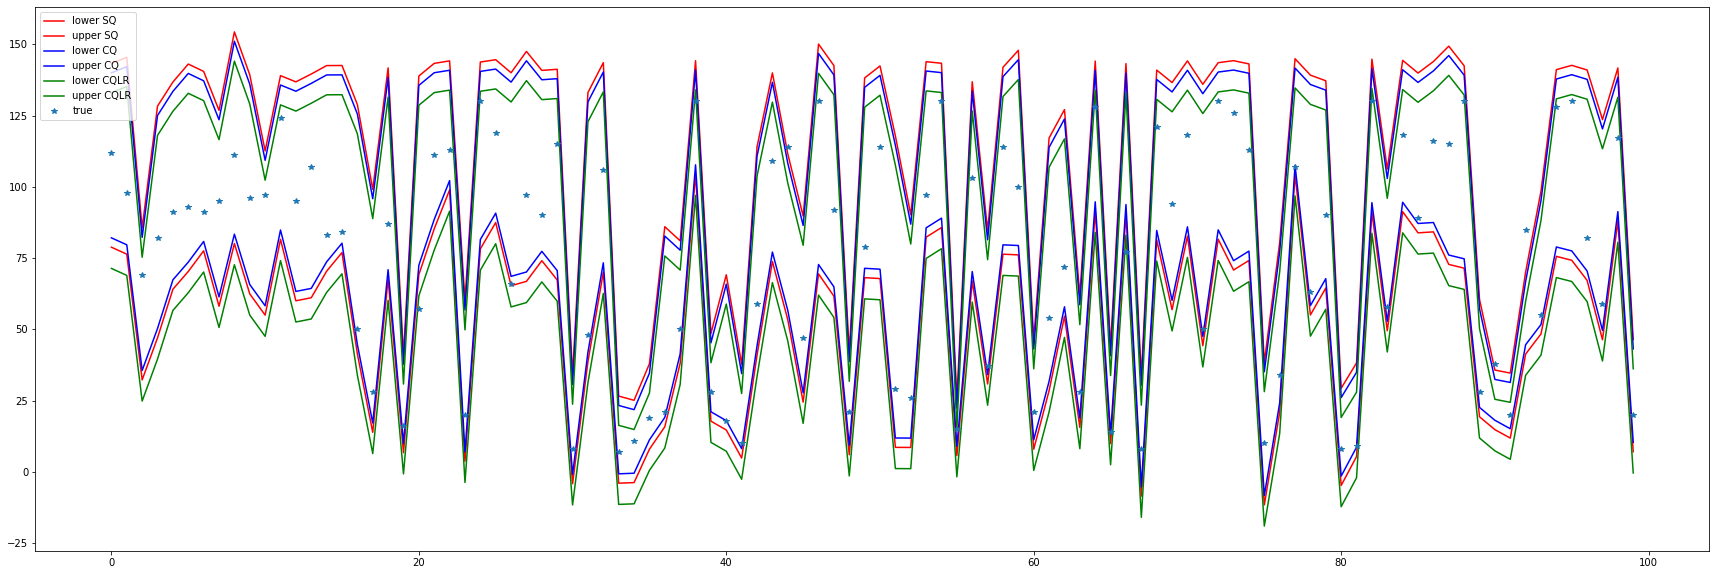

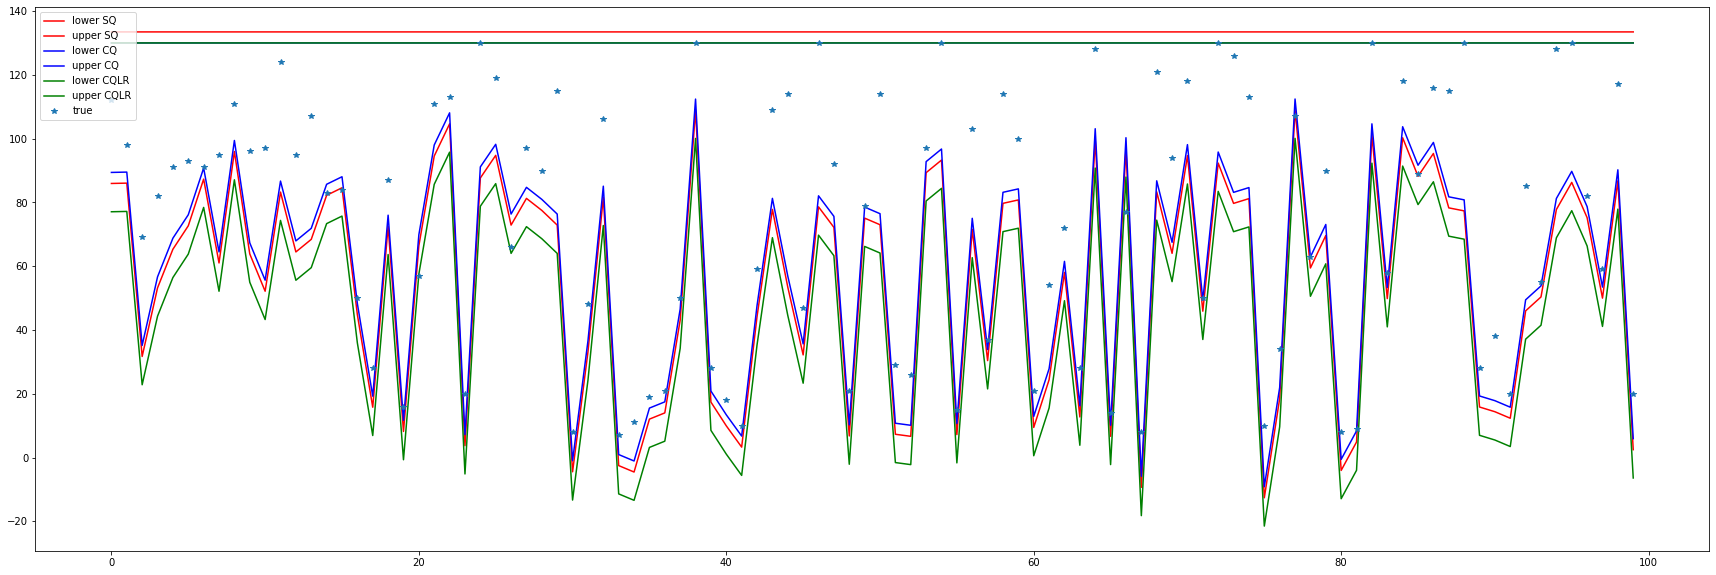

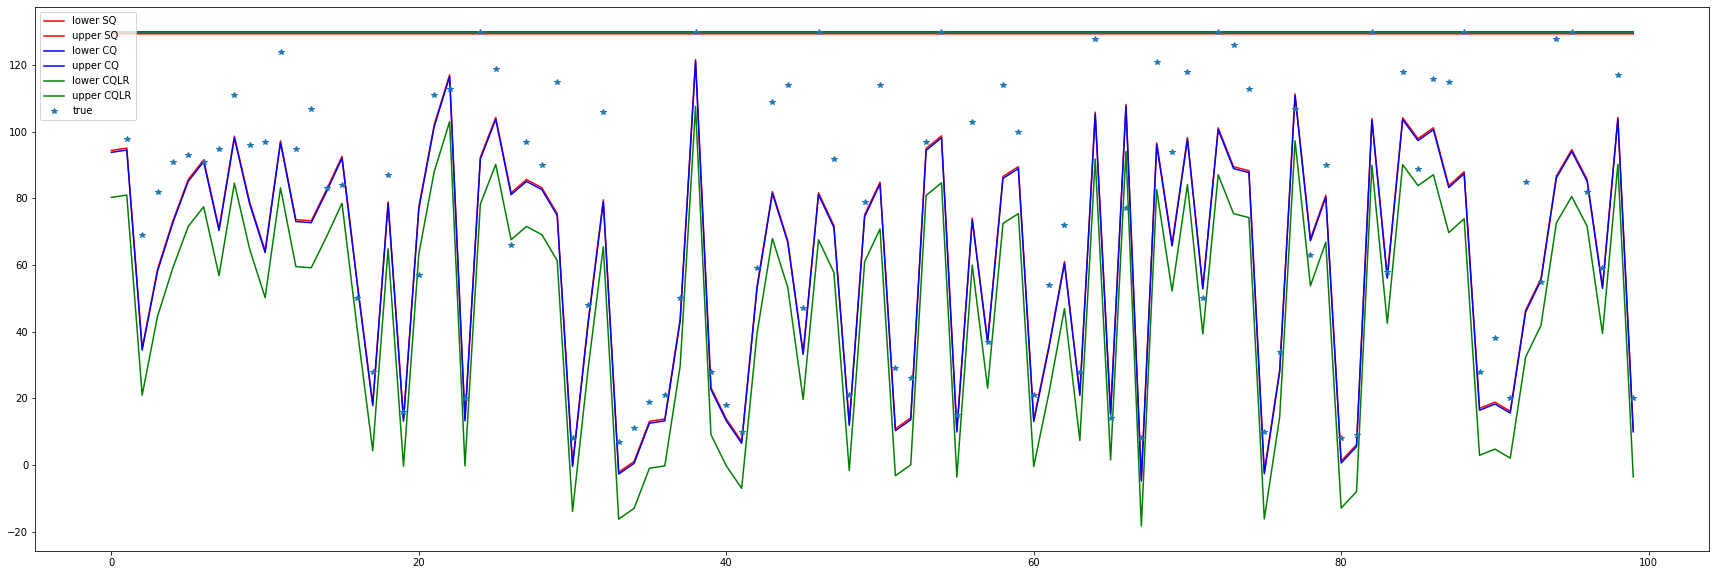

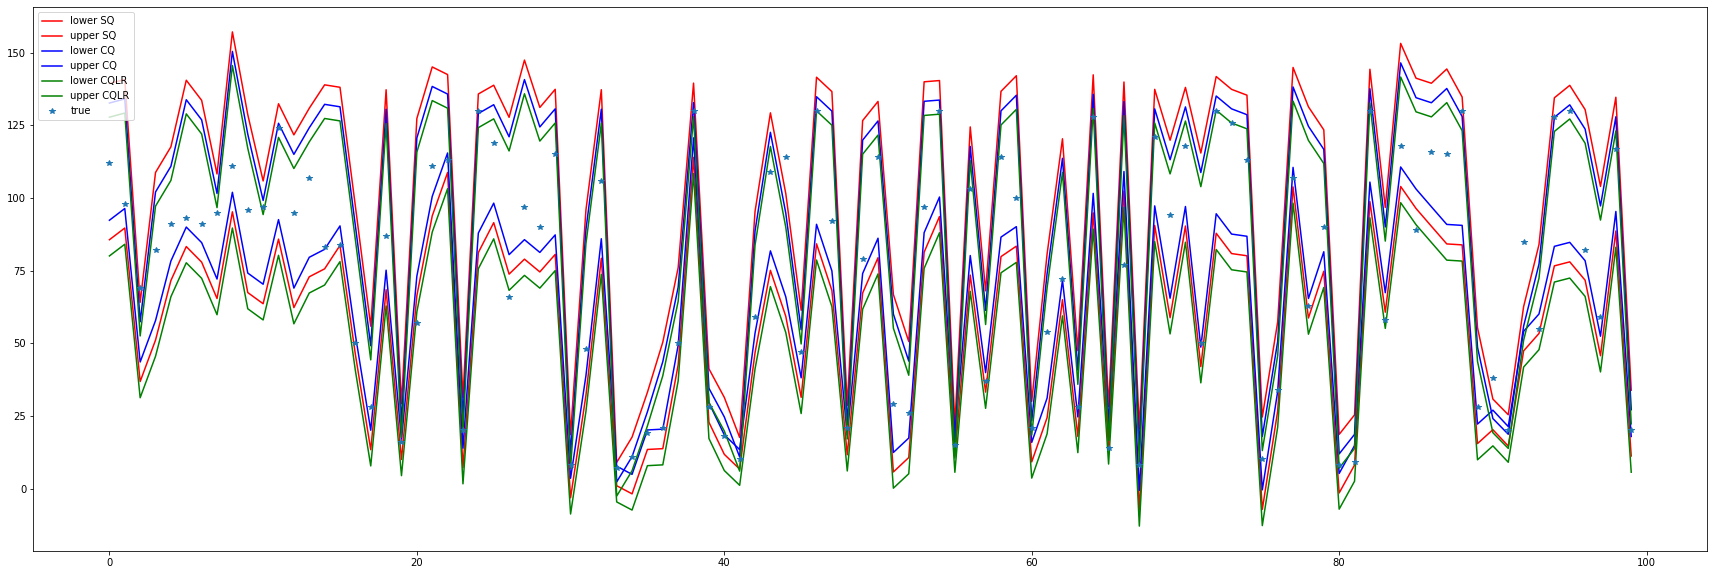

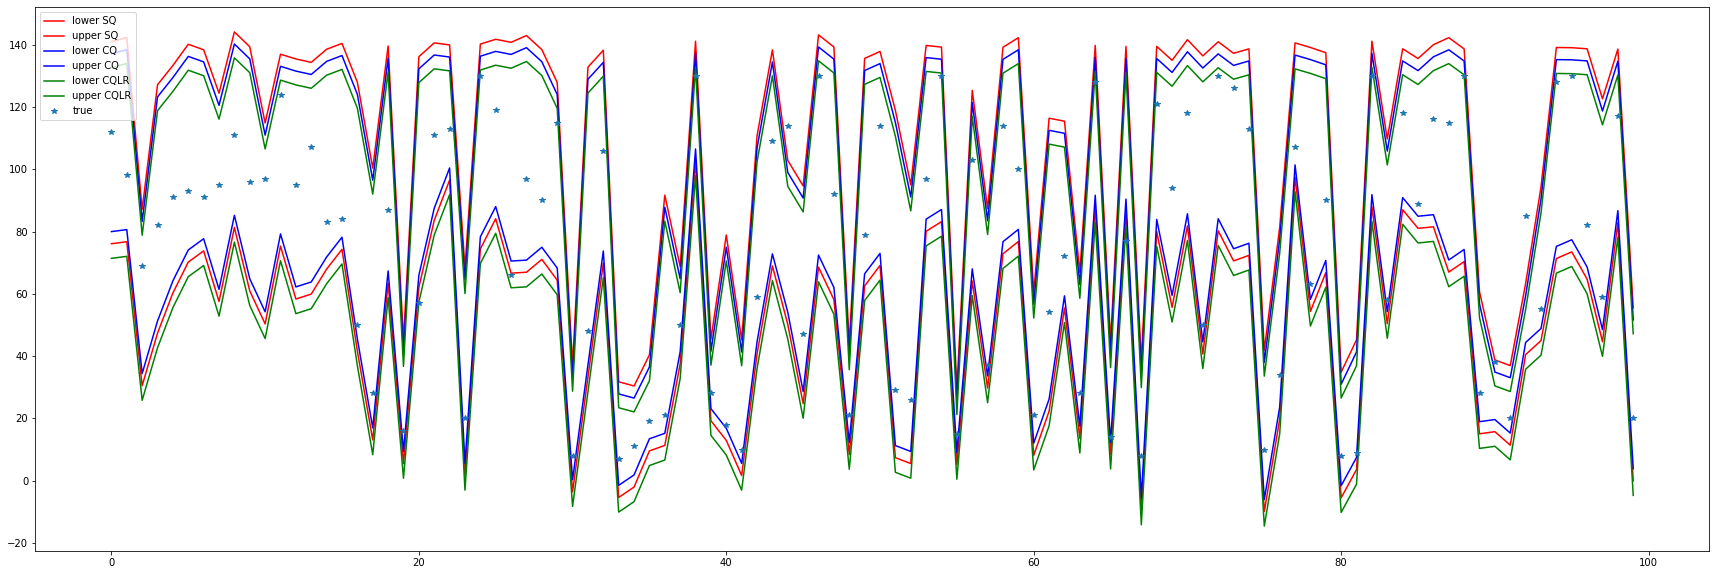

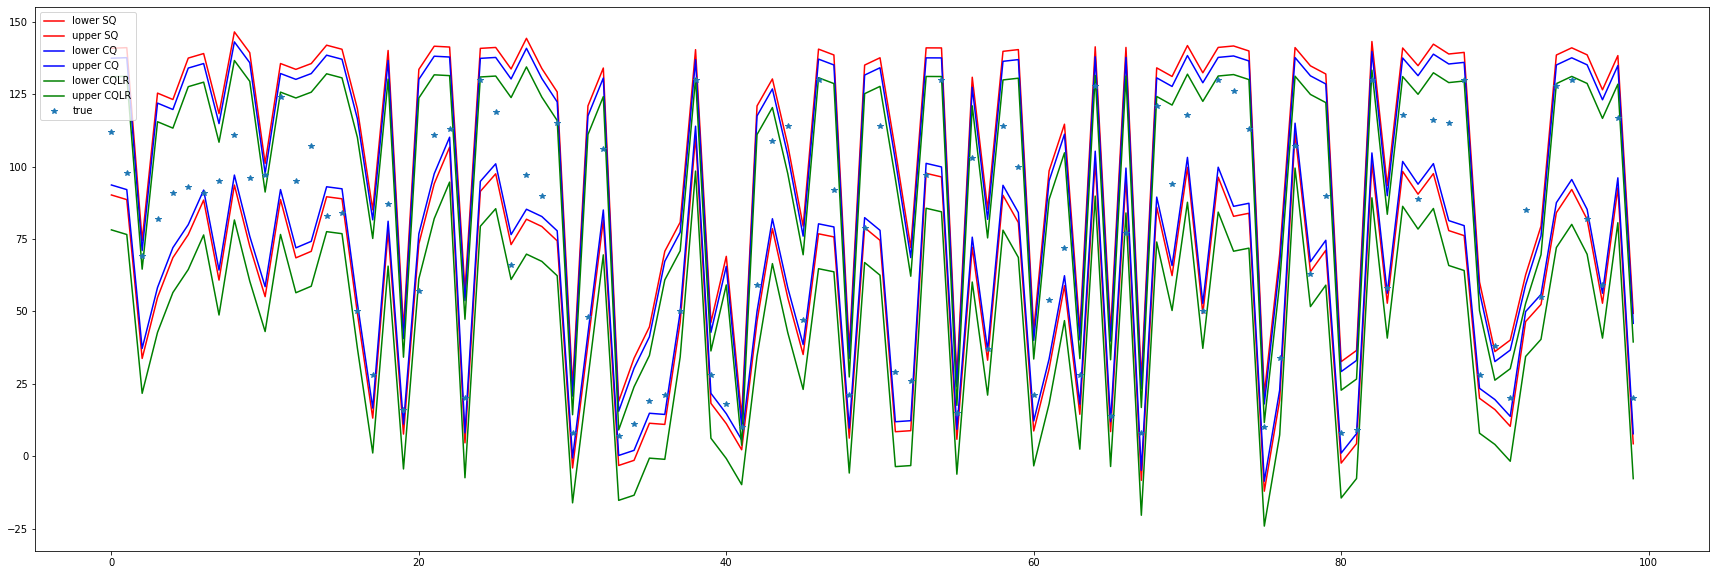

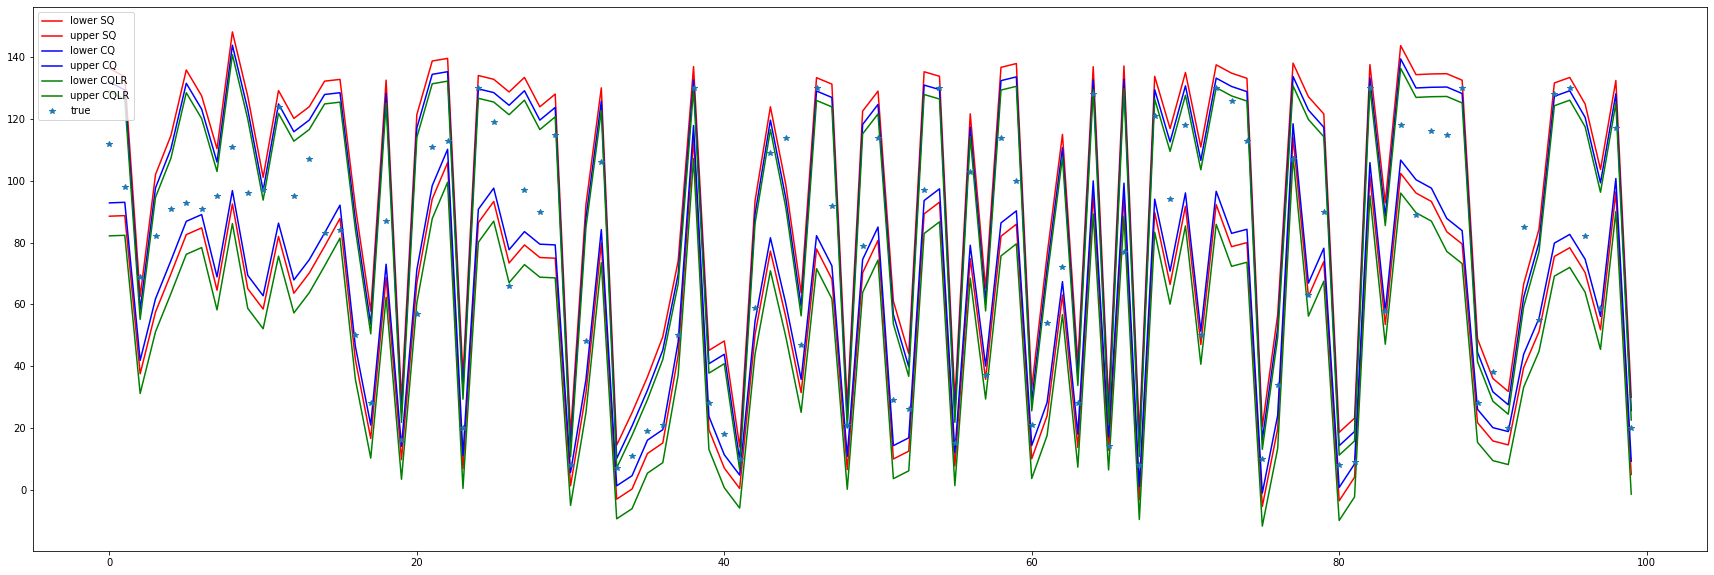

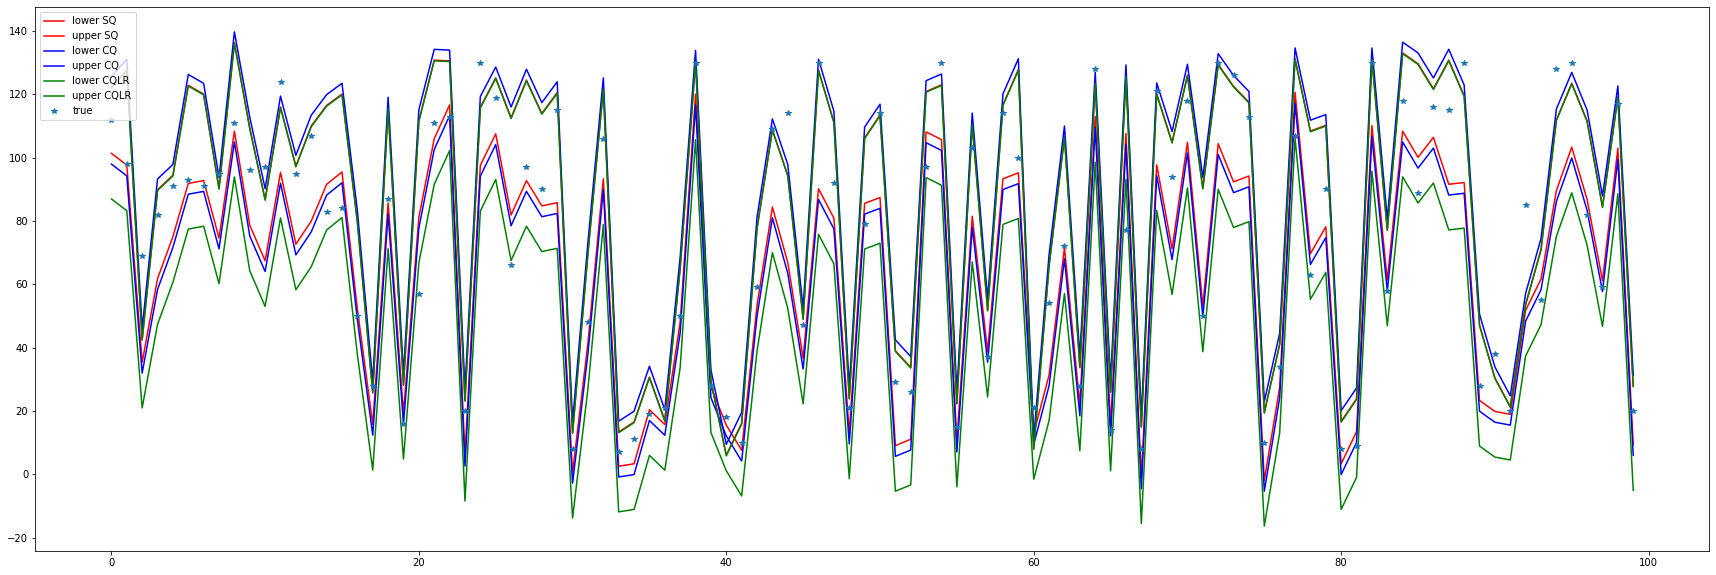

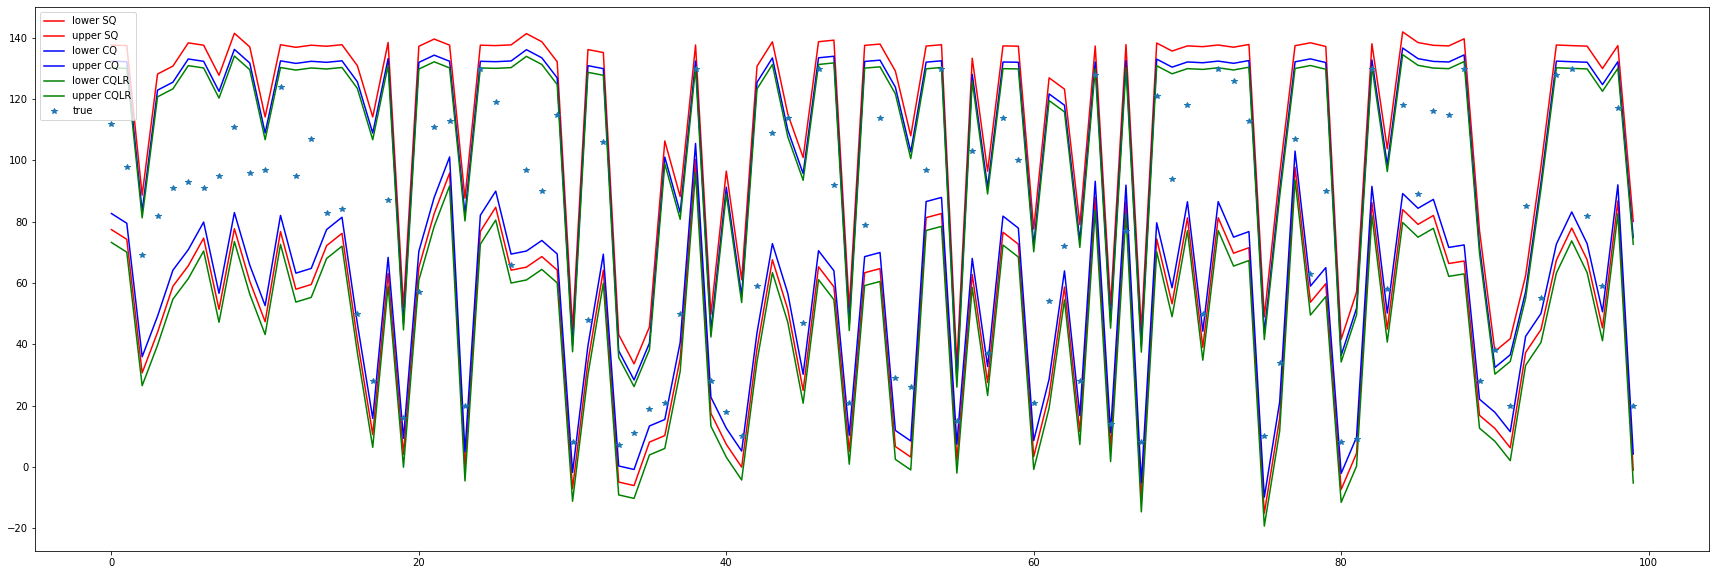

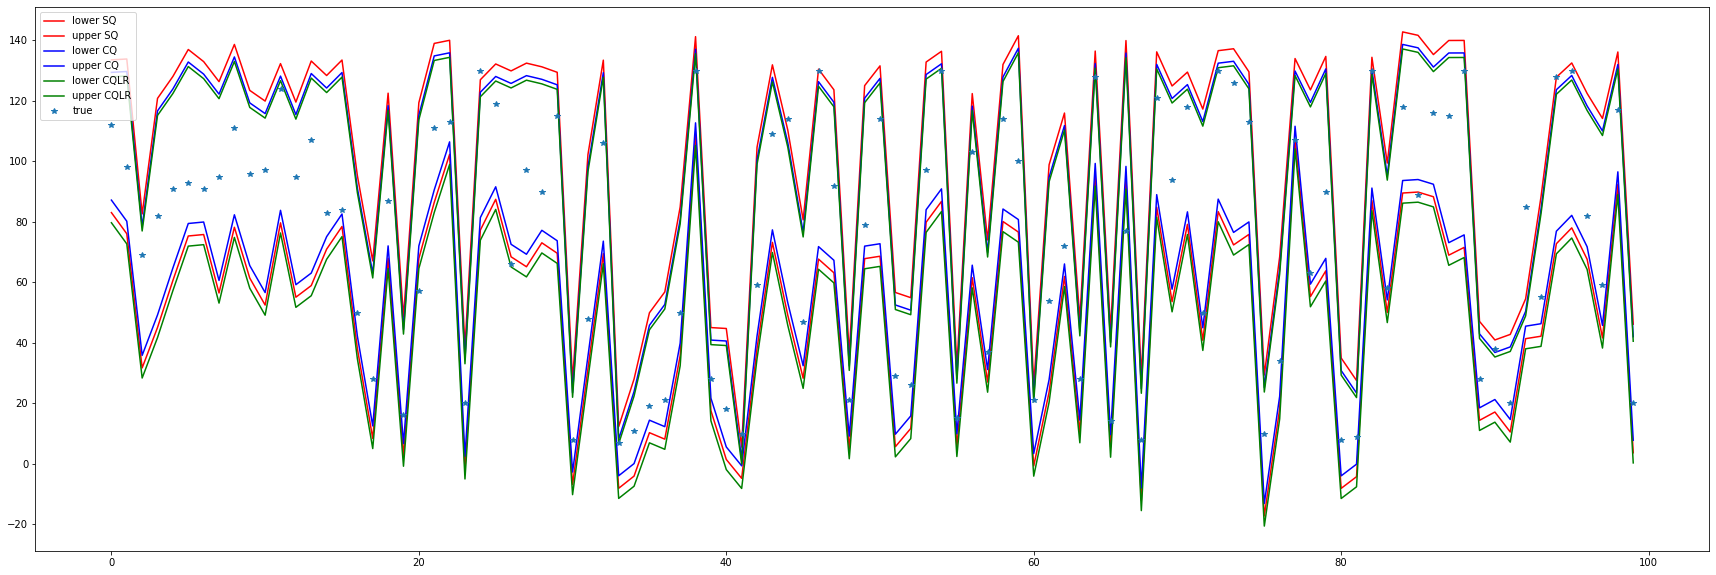

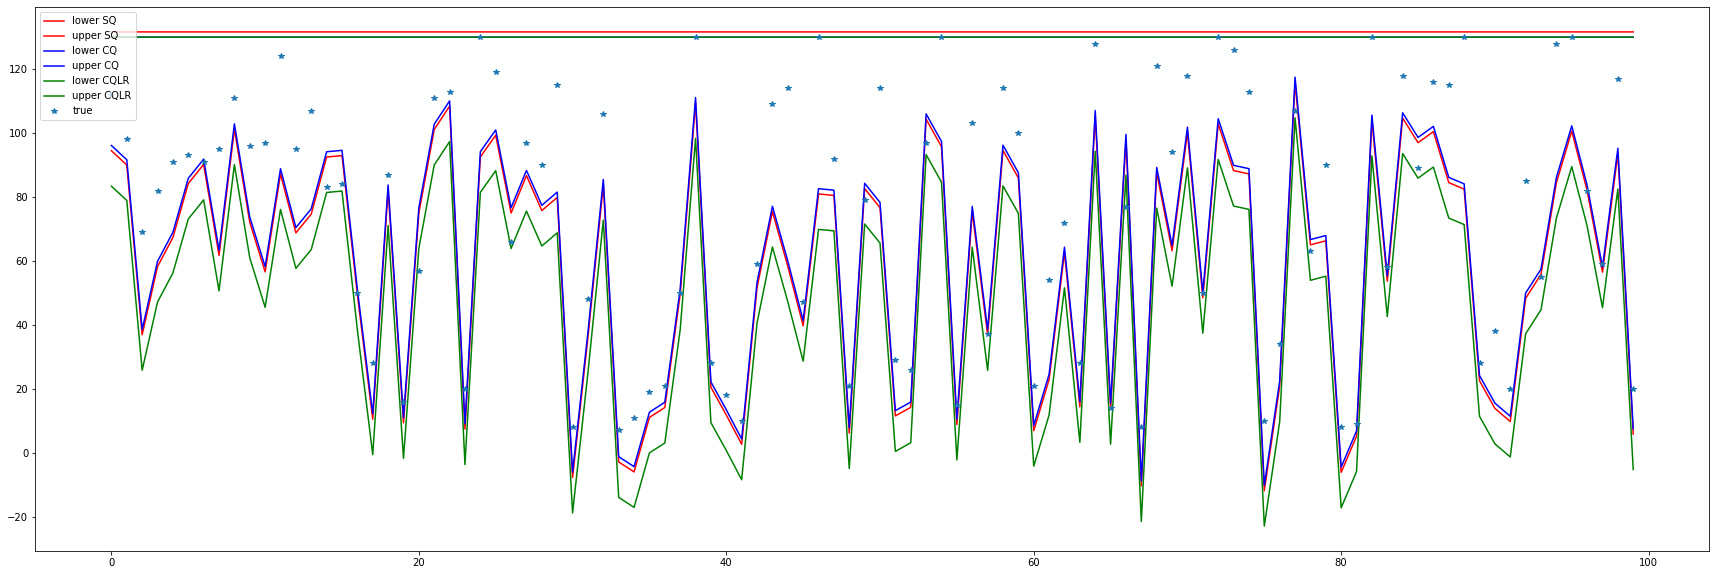

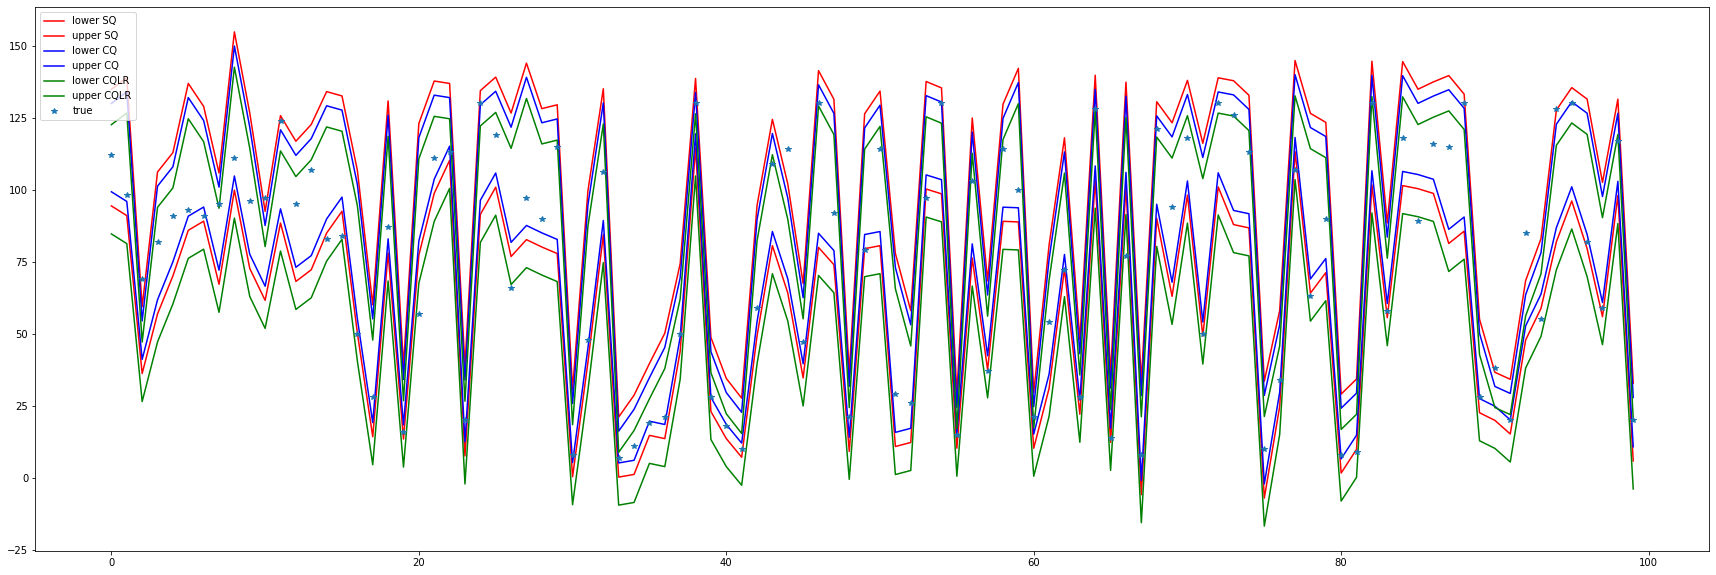

In [24]:


epochs = 50
optimizer = Adam(learning_rate=1e-3)
alpha_list = [0.1, 0.2, 0.3, 0.4]
calib_size_list = [0.1, 0.2, 0.3, 0.4, 0.5]

# model_median = create_model(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
# model_mean   = create_model(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
# model_median.compile(optimizer=optimizer, loss=lambda y_true,y_pred: quantile_loss(0.5,y_true,y_pred), metrics=[RootMeanSquaredError()])
# model_mean.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])


''' 
 key is a tuple ('model', calib_size, alpha)
 models:
     SQ: simple quantile regression 
     CQ: Conformalized quantile regression  
     CQLR: Conformalized quantile regression with independent left and right tails controlling
''' 
# average length dictionary
AL_dic = {}
# coverage percentage dictionary 
CP_dic = {}
# late predictions percentage dictionary 
LPP_dic = {}
# q dictionary 
q_dic = {}

for calib_size in calib_size_list:
    
    X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=calib_size, random_state=42)
    # number of calibration data
    n = X_calib.shape[0]
    for alpha in alpha_list:
        model_low = create_model(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
        model_high = create_model(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
        model_low.compile(optimizer=optimizer, loss=lambda y_true,y_pred: quantile_loss(alpha/2,y_true,y_pred), metrics=[RootMeanSquaredError()])
        model_high.compile(optimizer=optimizer, loss=lambda y_true,y_pred: quantile_loss(1-alpha/2,y_true,y_pred), metrics=[RootMeanSquaredError()])
        model_low.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)
        model_high.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)
        
        # nonconformity scores
        scores_low = model_low.predict(X_calib) - y_calib
        scores_high = y_calib - model_high.predict(X_calib) 
        scores = np.maximum(scores_low, scores_high)

        # compute quantile of scores
        q = np.quantile(scores, np.ceil((n+1)*(1-alpha))/n)

        # compute different quantiles for upper and lower bounds
        alpha_low = alpha/10
        alpha_high = alpha - alpha_low
        q_low = np.quantile(scores_low, np.ceil((n+1)*(1-alpha_low))/n)
        q_high = np.quantile(scores_high, np.ceil((n+1)*(1-alpha_high))/n)

        # store q's 
        q_dic[(calib_size, alpha)] = (q, q_low, q_high)

        # coverage percentage
        CP_dic[('SQ', calib_size, alpha)] = sum((y_test >= (model_low.predict(X_test))) & (y_test <= (model_high.predict(X_test))))/y_test.shape[0]
        CP_dic[('CQ', calib_size, alpha)] = sum((y_test >= (model_low.predict(X_test) - q)) & (y_test <= (model_high.predict(X_test) + q)))/y_test.shape[0]
        CP_dic[('CQLR', calib_size, alpha)] = sum((y_test >= (model_low.predict(X_test) - q_low)) & (y_test <= (model_high.predict(X_test) + q_high)))/y_test.shape[0]
        
        # mean interval length   
        AL_dic[('SQ', calib_size, alpha)] = np.mean(model_high.predict(X_test) - model_low.predict(X_test))
        AL_dic[('CQ', calib_size, alpha)] = np.mean(model_high.predict(X_test) + q - model_low.predict(X_test) + q)
        AL_dic[('CQLR', calib_size, alpha)] = np.mean(model_high.predict(X_test) + q_high - model_low.predict(X_test) + q_low)

        # uncovered points below the lower bound
        LPP_dic[('SQ', calib_size, alpha)] = sum(y_test >= (model_low.predict(X_test)))
        LPP_dic[('CQ', calib_size, alpha)] = sum(y_test >= (model_low.predict(X_test) -q))
        LPP_dic[('CQLR', calib_size, alpha)] = sum(y_test >= (model_low.predict(X_test) -q_low))
        
        #plot
        plt.figure(figsize=(30, 10))
        plt.plot(model_low.predict(X_test), 'r', label='lower SQ')
        plt.plot(model_high.predict(X_test), 'r', label='upper SQ')
        plt.plot(model_low.predict(X_test) - q, 'b', label='lower CQ')
        plt.plot(model_high.predict(X_test) + q, 'b', label='upper CQ')
        plt.plot(model_low.predict(X_test) - q_low, 'g', label='lower CQLR')
        plt.plot(model_high.predict(X_test) + q_high, 'g', label='upper CQLR')
        plt.plot(y_test, '*', label='true')
        plt.legend(loc="upper left")

# Average length plots

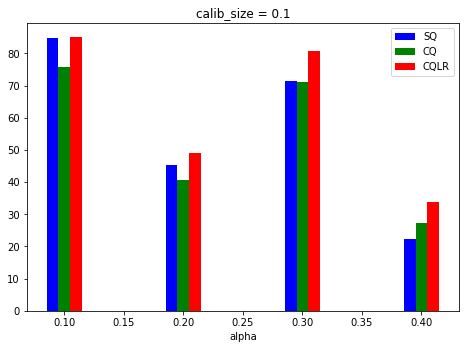

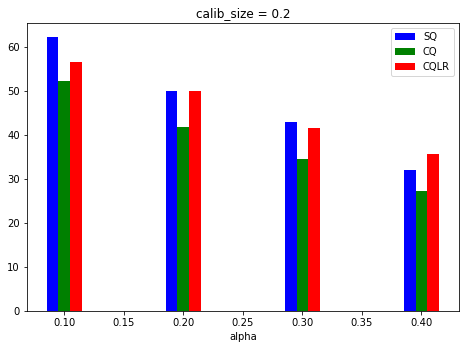

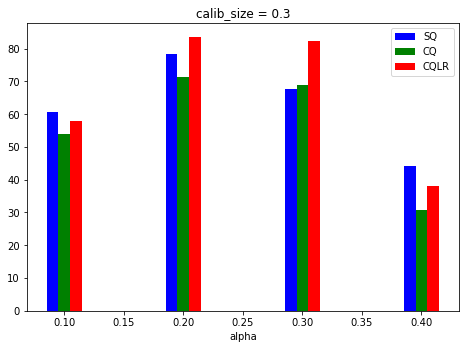

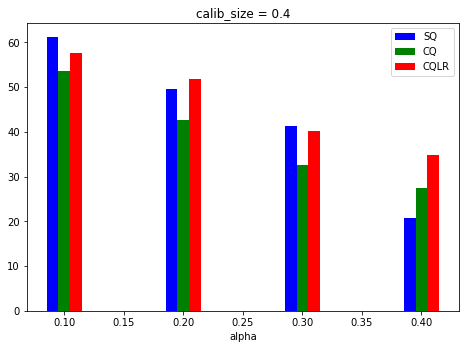

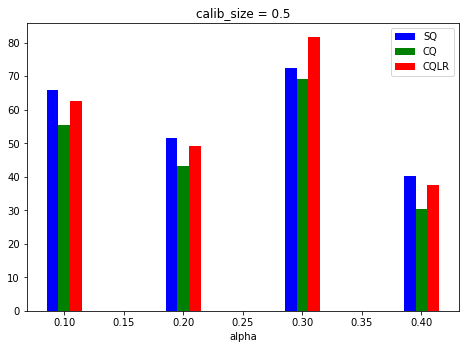

In [51]:
dic = AL_dic
width = 0.01
for calib_size in calib_size_list:
    SQ = []
    CQ = []
    CQLR = []
    for alpha in alpha_list:
        SQ.append(dic[('SQ', calib_size, alpha)])
        CQ.append(dic[('CQ', calib_size, alpha)])
        CQLR.append(dic[('CQLR', calib_size, alpha)])
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(np.array(alpha_list) - width, SQ, color = 'b', width = width, label = 'SQ')
    ax.bar(np.array(alpha_list), CQ, color = 'g', width = width, label = 'CQ')
    ax.bar(np.array(alpha_list) + width, CQLR, color = 'r', width = width, label = 'CQLR')
    ax.legend()
    plt.title(f'calib_size = {calib_size}')
    plt.xlabel('alpha')

# Coverage Percentage plots

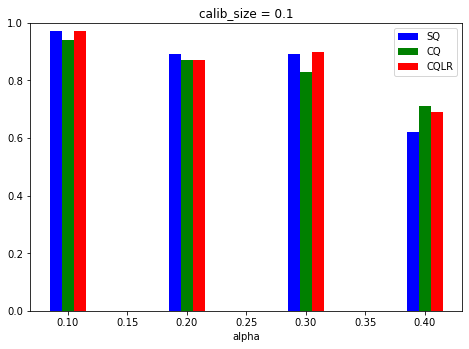

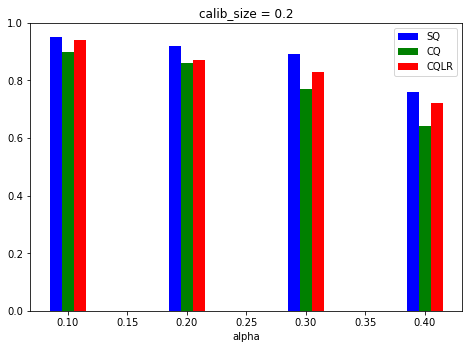

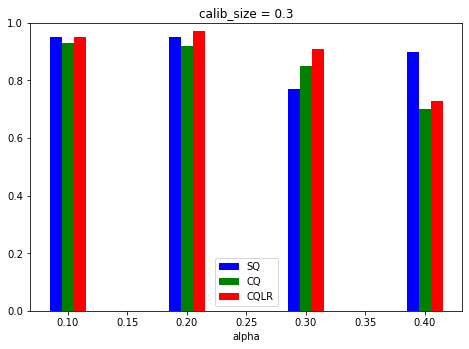

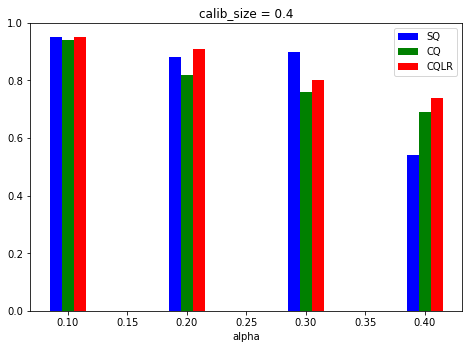

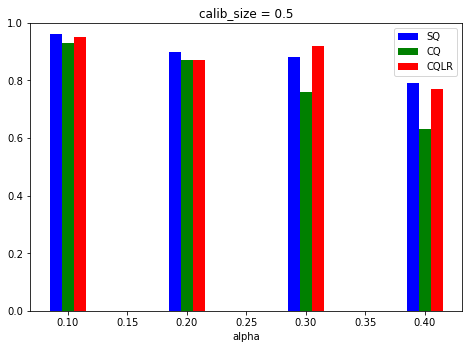

In [66]:
dic = CP_dic
width = 0.01
for calib_size in calib_size_list:
    SQ = []
    CQ = []
    CQLR = []
    for alpha in alpha_list:
        SQ.append(dic[('SQ', calib_size, alpha)][0])
        CQ.append(dic[('CQ', calib_size, alpha)][0])
        CQLR.append(dic[('CQLR', calib_size, alpha)][0])
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(np.array(alpha_list) - width, SQ, color = 'b', width = width, label = 'SQ')
    ax.bar(np.array(alpha_list), CQ, color = 'g', width = width, label = 'CQ')
    ax.bar(np.array(alpha_list) + width, CQLR, color = 'r', width = width, label = 'CQLR')
    ax.legend()
    plt.title(f'calib_size = {calib_size}')
    plt.xlabel('alpha')
    plt.ylim([0,1])

In [53]:
model_low.evaluate(X_train, y_train)

278/278 [==============================] - 4s 14ms/step - loss: 135.1097 - root_mean_squared_error: 23.2324


[135.10971069335938, 23.232376098632812]

In [54]:
model_high.evaluate(X_train, y_train)

278/278 [==============================] - 2s 6ms/step - loss: 153.0164 - root_mean_squared_error: 28.7397


[153.0164337158203, 28.73966407775879]

In [55]:
model_low.evaluate(X_test, y_test)
model_high.evaluate(X_test, y_test)

4/4 [==============================] - 0s 15ms/step - loss: 170.9326 - root_mean_squared_error: 30.6746


[170.93255615234375, 30.674633026123047]

In [65]:
model_low.evaluate(X_calib, y_calib)
model_high.evaluate(X_calib, y_calib)

278/278 [==============================] - 4s 13ms/step - loss: 155.1601 - root_mean_squared_error: 29.2015


[155.16009521484375, 29.201465606689453]

In [56]:
n

8866

In [60]:
np.mean(np.abs(model_low.predict(X_test) - y_test))

4/4 [==============================] - 0s 11ms/step


16.49238

In [61]:
np.std(np.abs(model_low.predict(X_test) - y_test))

4/4 [==============================] - 0s 13ms/step


12.681389

278/278 [==============================] - 4s 13ms/step


(array([2584., 2011., 1404.,  971.,  770.,  578.,  368.,  136.,   31.,
          13.]),
 array([1.7242432e-03, 7.5632172e+00, 1.5124710e+01, 2.2686203e+01,
        3.0247696e+01, 3.7809189e+01, 4.5370682e+01, 5.2932175e+01,
        6.0493668e+01, 6.8055161e+01, 7.5616653e+01], dtype=float32),
 <BarContainer object of 10 artists>)

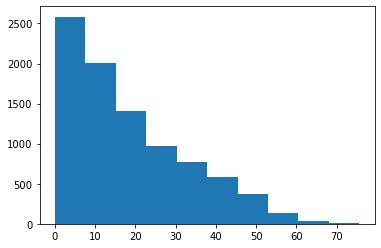

In [64]:
plt.hist(np.abs(model_low.predict(X_calib) - y_calib))

In [63]:
np.std(np.abs(model_low.predict(X_test) - y_test)) * np.sqrt(1/9)

4/4 [==============================] - 0s 8ms/step


4.227129618326822

# How is the histogram of the prediction set size?
A wider spread is generally desirable, since it means that the
procedure is effectively distinguishing between easy and hard inputs.
 

4/4 [==============================] - 0s 10ms/step


(array([ 5.,  6.,  8., 12., 20., 21., 22.,  2.,  3.,  1.]),
 array([ 21.930685,  29.841705,  37.752728,  45.663746,  53.574768,
         61.48579 ,  69.39681 ,  77.30783 ,  85.21885 ,  93.129875,
        101.04089 ], dtype=float32),
 <BarContainer object of 10 artists>)

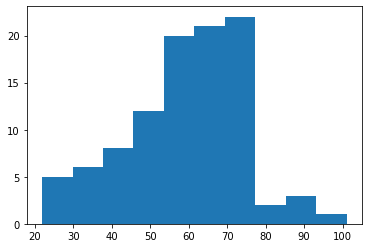

In [143]:
plt.hist(model_high.predict(X_test) - model_low.predict(X_test))

# Is there a relation between the true labels(RUL) and the interval lengths? 
Can we see that the higher the RUL, the higher the length? 

4/4 [==============================] - 0s 9ms/step


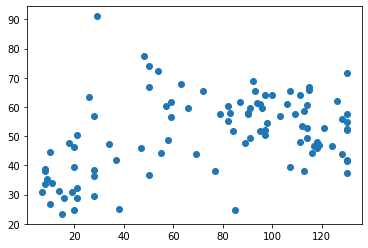

In [123]:
plt.scatter(y_test, model_high.predict(X_test) - model_low.predict(X_test))

# How about the available data points? 
Is it the case that the more data we have the smaller the prediction intervals? 

4/4 [==============================] - 0s 9ms/step


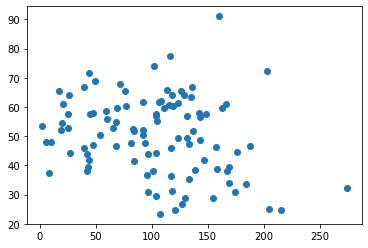

In [124]:
leng = []
for i in range(len(test[0])):
    leng.append(test[0][i].shape[0])

plt.scatter(leng, model_high.predict(X_test) - model_low.predict(X_test))